---
<H1 style="text-align:center;">Data Analysis of "Mental Health and Social Media Balance Dataset"</H1>
<H4 style="text-align:center;">by Volodymyr Babunych</H3> <br><br>
  <img src="image1.jpg" alt="Alt text" width="400" style="display: block; margin-left: auto; margin-right: auto;">

---
Objective:
To analyze the relationship between social media usage, screen time, lifestyle factors, and mental health indicators (happiness, stress, sleep quality) to identify patterns, correlations, and insights that can inform better mental well-being practices.

Key Questions to Answer:
- How do daily screen time and social media usage relate to stress level, sleep quality, and happiness?
- Does exercise frequency influence mental health indicators?
- Are there significant differences in mental health metrics across age groups or gender?
- Which social media platforms are associated with higher/lower stress or happiness levels?
- How do periods without social media affect stress and happiness?


---
## 1. Import of Libraries:
___

In [48]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import optuna
import logging
import warnings
import plotly.graph_objects as go
import plotly.express as px
import pickle
import gradio as gr
warnings.simplefilter(action='ignore', category=FutureWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
from feature_engine.outliers import Winsorizer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, gaussian_kde, spearmanr

---
## 2. Load data:
---

In [2]:
"""

Data source: https://www.kaggle.com/datasets/ayeshaimran123/social-media-and-mental-health-balance/data
This dataset provides statistical data of social media users and their mental health indicators like stress and happiness levels.
Potential biases (self-reported data, small sample=500)

"""
df = pd.read_csv("Mental_Health_and_Social_Media_Balance_Dataset.csv")

---
## 3. Check the data for cleaning and preprocessing needs:
---

In [3]:
# Rows and columns count:
print("rows and columns:\n")
df.shape

rows and columns:



(500, 10)

In [4]:
# Data view:
df.head(3)

,User_ID,Age,Gender,Daily_Screen_Time(hrs),Sleep_Quality(1-10),Stress_Level(1-10),Days_Without_Social_Media,Exercise_Frequency(week),Social_Media_Platform,Happiness_Index(1-10)
0,U001,44,Male,3.1,7.0,6.0,2.0,5.0,Facebook,10.0
1,U002,30,Other,5.1,7.0,8.0,5.0,3.0,LinkedIn,10.0
2,U003,23,Other,7.4,6.0,7.0,1.0,3.0,YouTube,6.0


In [5]:
df.tail(3)

,User_ID,Age,Gender,Daily_Screen_Time(hrs),Sleep_Quality(1-10),Stress_Level(1-10),Days_Without_Social_Media,Exercise_Frequency(week),Social_Media_Platform,Happiness_Index(1-10)
497,U498,41,Male,7.7,5.0,7.0,2.0,2.0,LinkedIn,8.0
498,U499,23,Male,4.2,9.0,7.0,0.0,2.0,Facebook,9.0
499,U500,43,Female,5.9,5.0,8.0,3.0,3.0,X (Twitter),7.0


In [6]:
# Structure and data types:
df.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   User_ID                    500 non-null    object 
 1   Age                        500 non-null    int64  
 2   Gender                     500 non-null    object 
 3   Daily_Screen_Time(hrs)     500 non-null    float64
 4   Sleep_Quality(1-10)        500 non-null    float64
 5   Stress_Level(1-10)         500 non-null    float64
 6   Days_Without_Social_Media  500 non-null    float64
 7   Exercise_Frequency(week)   500 non-null    float64
 8   Social_Media_Platform      500 non-null    object 
 9   Happiness_Index(1-10)      500 non-null    float64
dtypes: float64(6), int64(1), object(3)

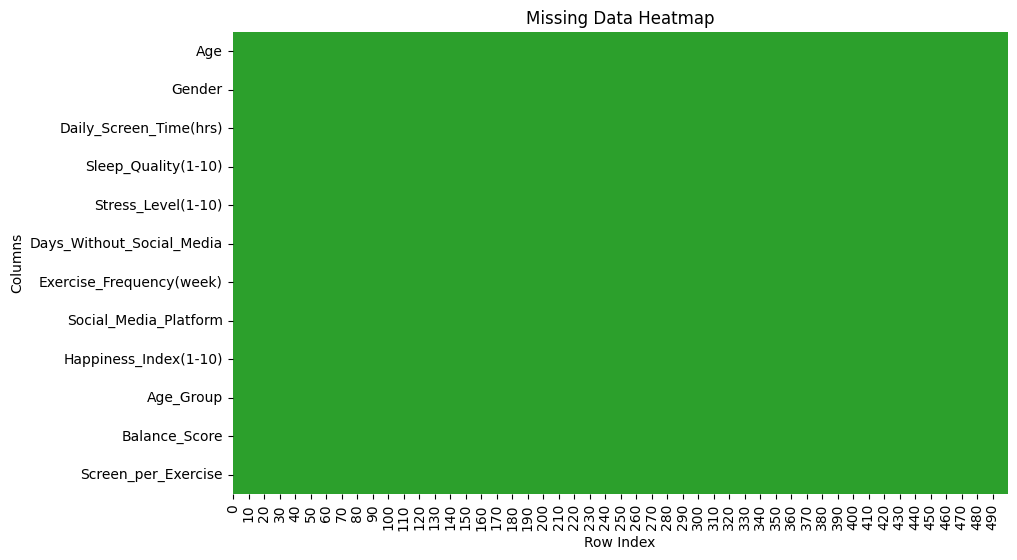

Missing Values per Column:
 Age                          0
Gender                       0
Daily_Screen_Time(hrs)       0
Sleep_Quality(1-10)          0
Stress_Level(1-10)           0
Days_Without_Social_Media    0
Exercise_Frequency(week)     0
Social_Media_Platform        0
Happiness_Index(1-10)        0
Age_Group                    0
Balance_Score                0
Screen_per_Exercise          0
dtype: int64


In [49]:
# Visualize missing values as heatmap with reversed axes
# Define two colors: one for False, one for True
cmap = ListedColormap(['#2ca02c', '#d62728'])  # green for present, red for missing
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull().T, cbar=False, cmap=cmap)
plt.title("Missing Data Heatmap")
plt.xlabel("Row Index")
plt.ylabel("Columns")
plt.show()

# Missing values
missing_summary = df.isna().sum()
print("Missing Values per Column:\n", missing_summary)

In [8]:
# Detect dublicates:
if df.duplicated(keep=False).any():  # check if there are any duplicates
    print("Duplicate rows found:")
    print(df[df.duplicated(keep=False)])
else:
    print("No duplicate rows found.")

No duplicate rows found.


In [9]:
# Check data ranges:
df.describe()

,Age,Daily_Screen_Time(hrs),Sleep_Quality(1-10),Stress_Level(1-10),Days_Without_Social_Media,Exercise_Frequency(week),Happiness_Index(1-10)
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,32.988000,5.530000,6.304000,6.618000,3.134000,2.448000,8.376000
std,9.960637,1.734877,1.529792,1.542996,1.858751,1.428067,1.524228
min,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,4.000000
25%,24.000000,4.300000,5.000000,6.000000,2.000000,1.000000,7.000000
50%,34.000000,5.600000,6.000000,7.000000,3.000000,2.000000,9.000000
75%,41.000000,6.700000,7.000000,8.000000,5.000000,3.000000,10.000000
max,49.000000,10.800000,10.000000,10.000000,9.000000,7.000000,10.000000


In [10]:
# Count users with Days_Without_Social_Media > 7
countMoreSeven = df.query("Days_Without_Social_Media > 7").shape[0]

# Get User_ID and Days_Without_Social_Media for those users
MoreSevenDisplay = df.query("Days_Without_Social_Media > 7")[["User_ID", "Days_Without_Social_Media"]].values

# Print results
print(f"Days Without Social Media > 7: {countMoreSeven}\nUsers and values: {MoreSevenDisplay}\n")

Days Without Social Media > 7: 1
Users and values: [['U450' 9.0]]



***! One user has Days_Without_Social_Media more than 7 (equal to 9), so I assume that metric is correct and is on monthly basis. All other ranges (like age, screen time seems to be fine)***

In [11]:
### Check unique values

# in num columns ():
def check_numeric_ranges(df):
    print("=== Numeric Columns Ranges ===")
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        min_val = df[col].min()
        max_val = df[col].max()
        print(f"{col}: min={min_val}, max={max_val}")
        
# in categorical columns:
def check_categorical_values(df):
    print("\n=== Categorical Columns Unique Values ===")
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        unique_vals = df[col].unique()
        print(f"{col}: {unique_vals}")

check_numeric_ranges(df)
check_categorical_values(df)

=== Numeric Columns Ranges ===
Age: min=16, max=49
Daily_Screen_Time(hrs): min=1.0, max=10.8
Sleep_Quality(1-10): min=2.0, max=10.0
Stress_Level(1-10): min=2.0, max=10.0
Days_Without_Social_Media: min=0.0, max=9.0
Exercise_Frequency(week): min=0.0, max=7.0
Happiness_Index(1-10): min=4.0, max=10.0

=== Categorical Columns Unique Values ===
User_ID: ['U001' 'U002' 'U003' 'U004' 'U005' 'U006' 'U007' 'U008' 'U009' 'U010'
 'U011' 'U012' 'U013' 'U014' 'U015' 'U016' 'U017' 'U018' 'U019' 'U020'
 'U021' 'U022' 'U023' 'U024' 'U025' 'U026' 'U027' 'U028' 'U029' 'U030'
 'U031' 'U032' 'U033' 'U034' 'U035' 'U036' 'U037' 'U038' 'U039' 'U040'
 'U041' 'U042' 'U043' 'U044' 'U045' 'U046' 'U047' 'U048' 'U049' 'U050'
 'U051' 'U052' 'U053' 'U054' 'U055' 'U056' 'U057' 'U058' 'U059' 'U060'
 'U061' 'U062' 'U063' 'U064' 'U065' 'U066' 'U067' 'U068' 'U069' 'U070'
 'U071' 'U072' 'U073' 'U074' 'U075' 'U076' 'U077' 'U078' 'U079' 'U080'
 'U081' 'U082' 'U083' 'U084' 'U085' 'U086' 'U087' 'U088' 'U089' 'U090'
 'U091' 'U0

***Each row has unique user id, that column has no great value and may be dropped***

In [12]:
df = df.drop(columns=['User_ID'])

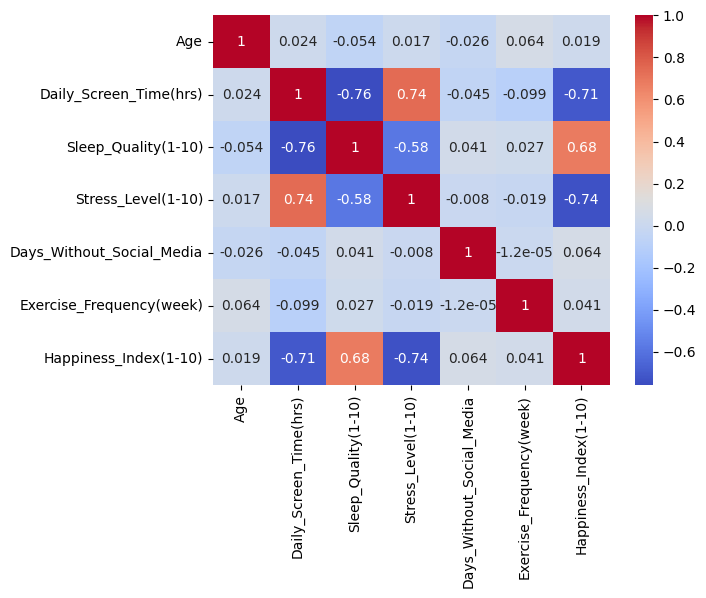

In [13]:
# Check for numeric correlation (to detect multicollinearity)
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.show()
print('\n')

***no serious multicollinearity***

**Summary: Looks data doesn't need cleaning for exploratory analysis.
Potential biases: self-reported data, small sample=500**

### 3.1 Feature Engeeniring

In [14]:
# Adds 2 features that may be helpful during ML and exploratory analysis
def add_interactions(df):
    """
    Input: DataFrame with original columns.
    Output: Same DataFrame + new engineered columns.
    """
    df = df.copy()
    
    # 1. Simple balance score
    df['Balance_Score'] = (
        (df['Exercise_Frequency(week)']+1) *
        (df['Days_Without_Social_Media']+1) /
        df['Daily_Screen_Time(hrs)']
    )
    
    # 2. Screen-time per exercise session
    df['Screen_per_Exercise'] = (
        df['Daily_Screen_Time(hrs)'] /
        (df['Exercise_Frequency(week)'] + 1)
    )
    
    return df

# Wrap for sklearn
interaction_transformer = FunctionTransformer(add_interactions)
add_interactions(df).head(3)

,Age,Gender,Daily_Screen_Time(hrs),Sleep_Quality(1-10),Stress_Level(1-10),Days_Without_Social_Media,Exercise_Frequency(week),Social_Media_Platform,Happiness_Index(1-10),Balance_Score,Screen_per_Exercise
0,44,Male,3.1,7.0,6.0,2.0,5.0,Facebook,10.0,5.806452,0.516667
1,30,Other,5.1,7.0,8.0,5.0,3.0,LinkedIn,10.0,4.705882,1.275000
2,23,Other,7.4,6.0,7.0,1.0,3.0,YouTube,6.0,1.081081,1.850000


---
## 4. Exploratory Data Analysis (EDA) with visualizations and insights:
---

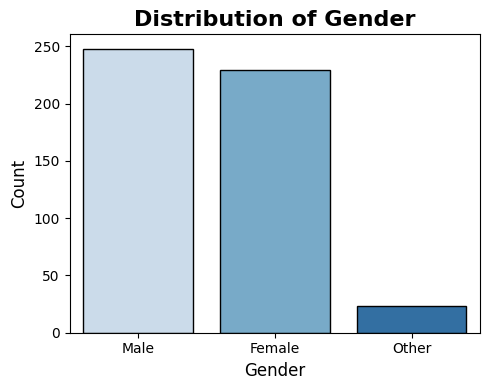

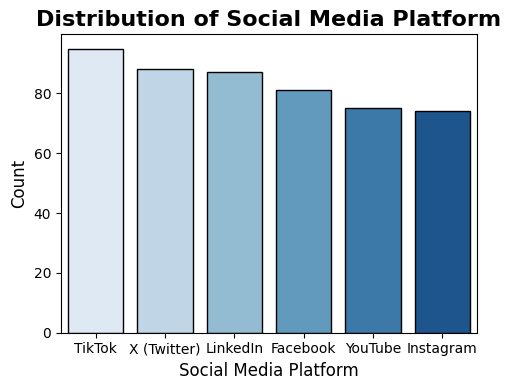

In [15]:
# Explore categorical sums:
categorical_cols = ['Gender', 'Social_Media_Platform']

# Custom pretty-label function (does NOT modify original df)
def pretty(col):
    return col.replace('_', ' ').replace('(1-10)', '').strip()

for col in categorical_cols:

    counts = df[col].value_counts()

    plt.figure(figsize=(5,4))
    
    sns.barplot(
        x=counts.index,
        y=counts.values,
        palette="Blues",
        edgecolor="black"
    )

    # Titles & labels
    plt.title(f"Distribution of {pretty(col)}", fontsize=16, weight="bold")
    plt.xlabel(pretty(col), fontsize=12)
    plt.ylabel("Count", fontsize=12)

    plt.tight_layout()
    plt.show()
    print('\n')


Data has almost equal spread between Male/Female users and Social Media Platforms.

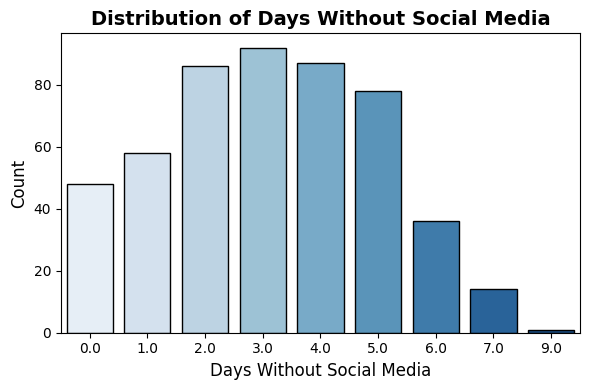

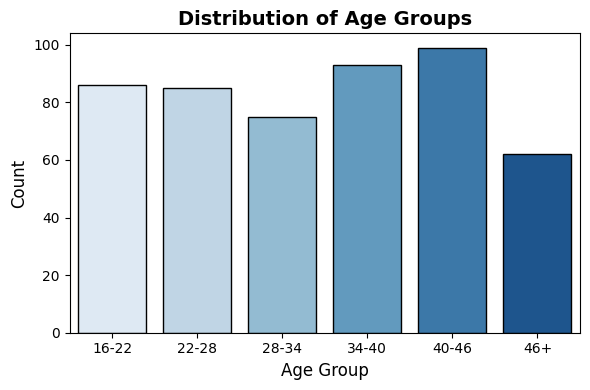

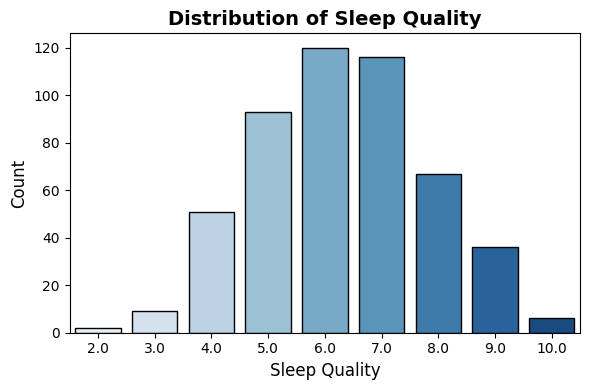

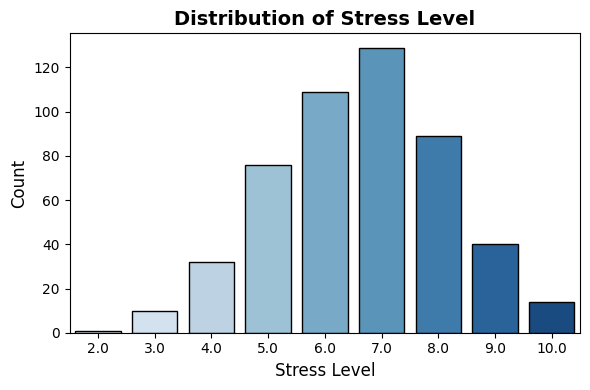

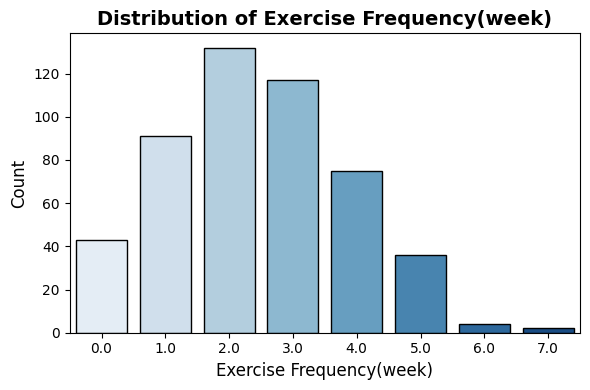

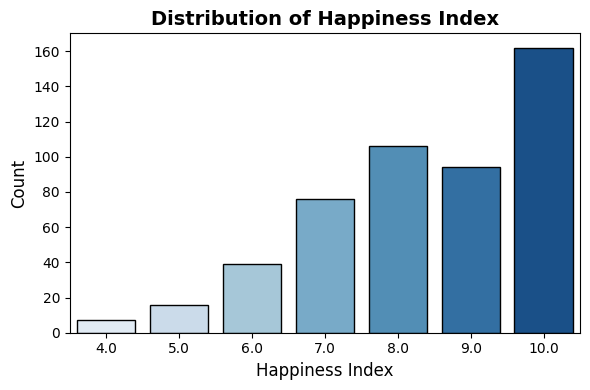

In [16]:
# Now lets explore numerical distributions

# List of numerical columns
num_cols = ['Days_Without_Social_Media', 'Age',
            'Sleep_Quality(1-10)', 'Stress_Level(1-10)',
            'Exercise_Frequency(week)', 'Happiness_Index(1-10)']

# Define age bins and labels
age_bins = [16, 22, 28, 34, 40, 46, 100]  # 100+ as upper bound
age_labels = ['16-22', '22-28', '28-34', '34-40', '40-46', '46+']

# Create Age Group column
df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

# Loop through columns
for col in num_cols:
    plt.figure(figsize=(6,4))
    
    if col == 'Age':
        # Use Age_Group instead of raw Age
        sns.countplot(x='Age_Group', data=df, palette="Blues", edgecolor="black")
        plt.xlabel("Age Group", fontsize=12)
        plt.title("Distribution of Age Groups", fontsize=14, weight="bold")
    else:
        sns.countplot(x=col, data=df, palette="Blues", edgecolor="black")
        plt.xlabel(pretty(col), fontsize=12)
        plt.title(f"Distribution of {pretty(col)}", fontsize=14, weight="bold")
    
    plt.ylabel("Count", fontsize=12)
    plt.tight_layout()
    plt.show()
    print('\n')

Paragraph summary:
- minority of users have 6 and more days a month without of social media;
- database covers all age groups from 16-50;
- most of users have average sleep quality and stress level;
- minority of users have exercises 5 or more days a week;
- most of users are happy.


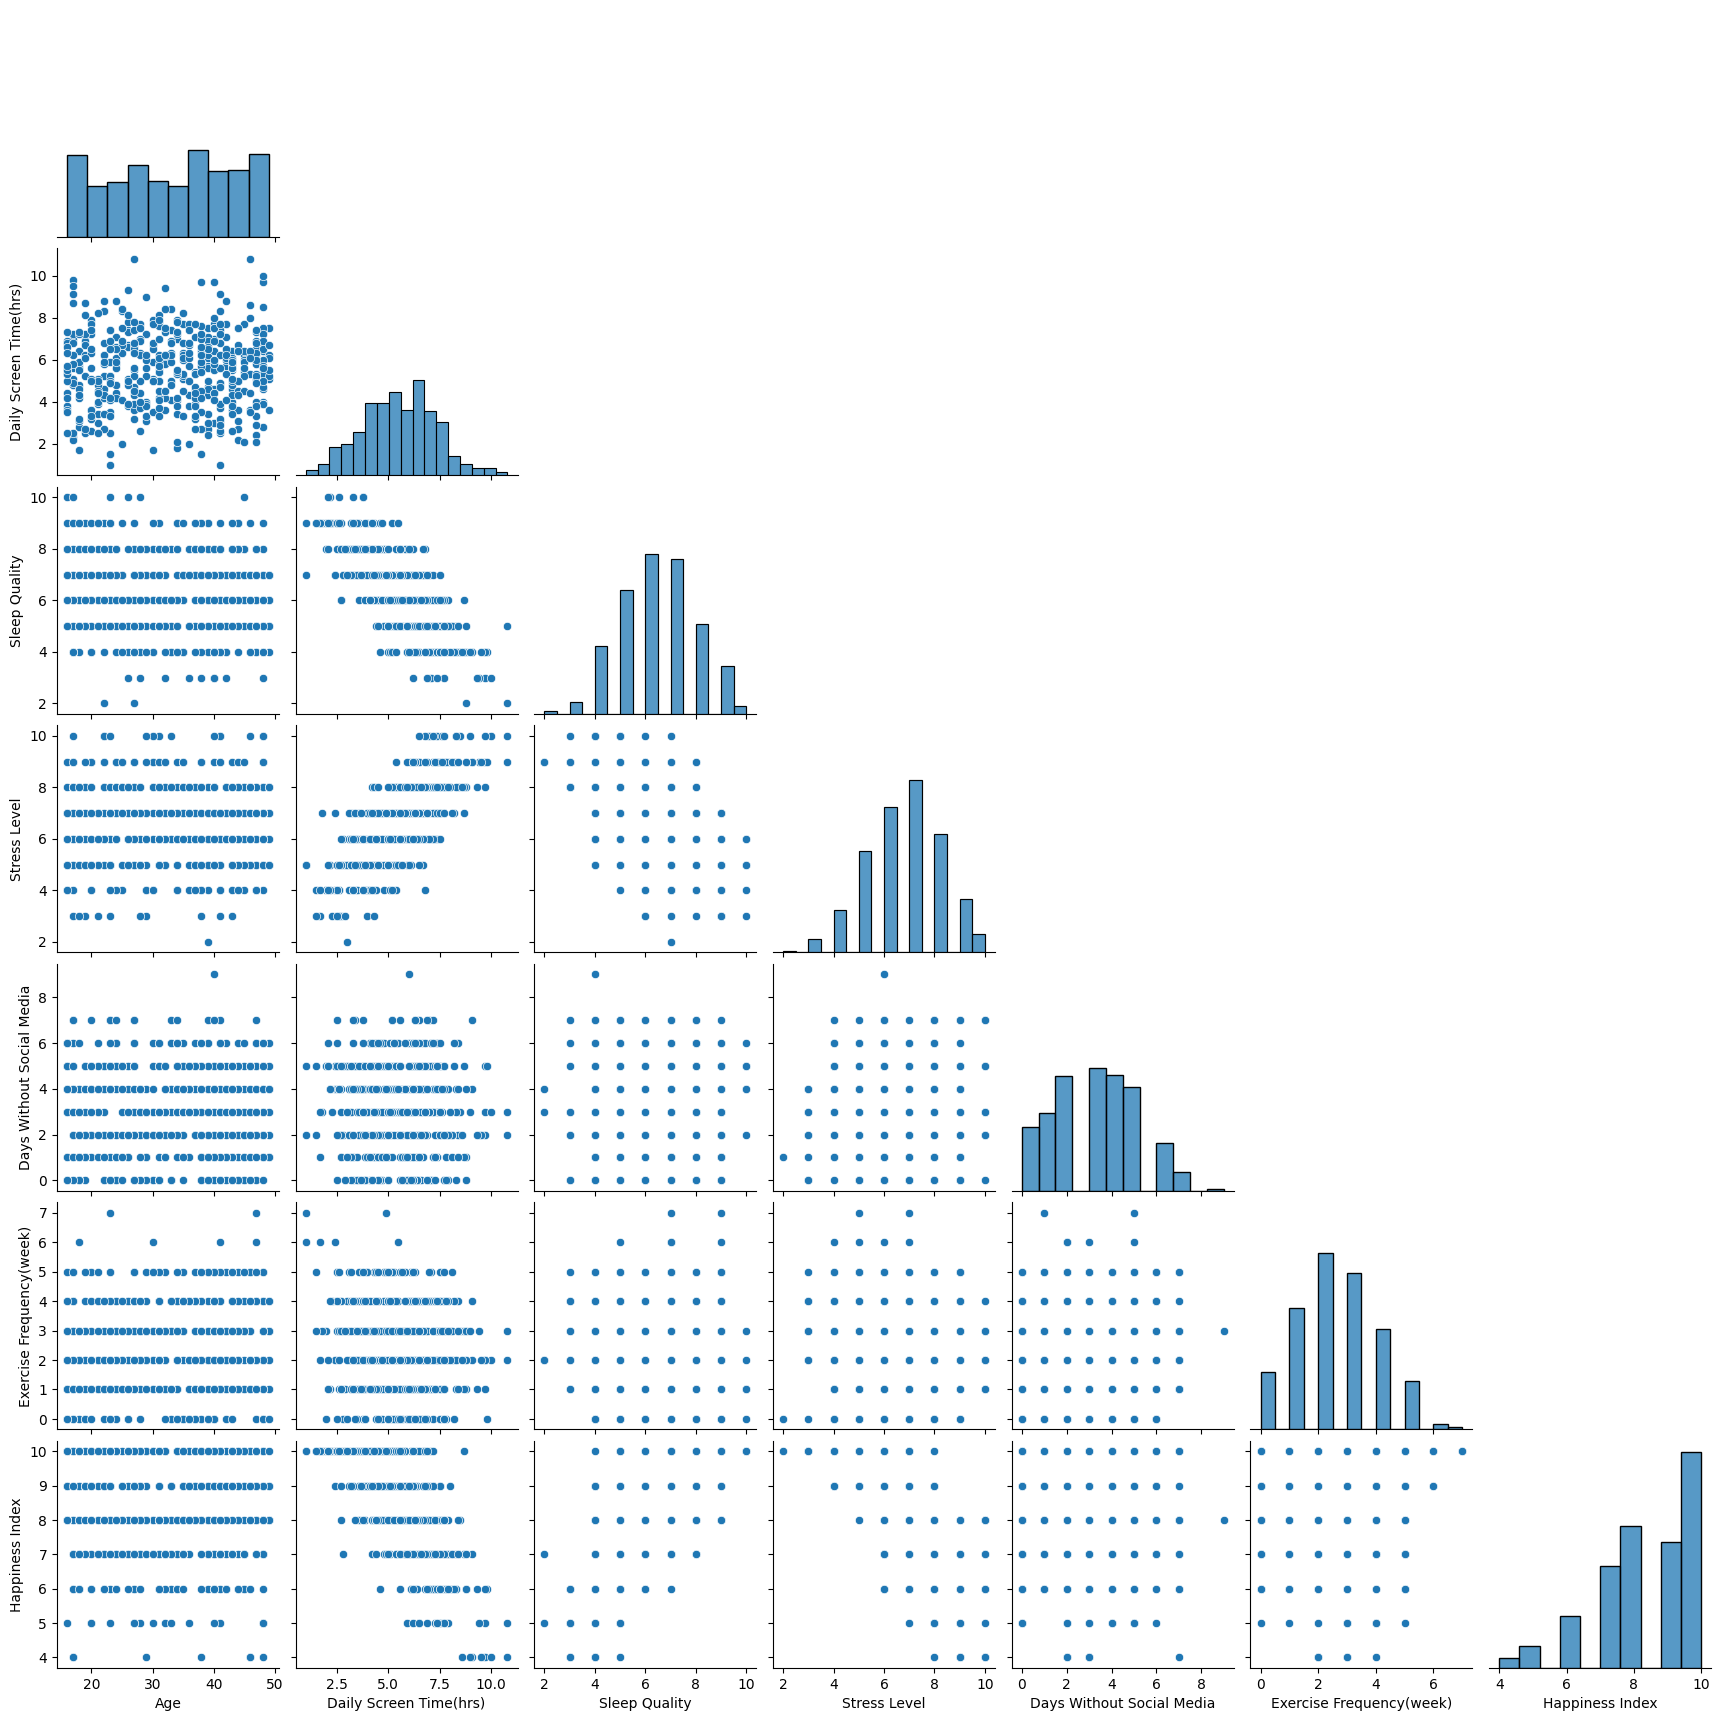

In [17]:
# Explore pairs relations; drop non-numeric columns for pairplot:
numeric_cols = df.select_dtypes(include='number').columns

# Rename the columns for prettier labels
pretty_cols = {col: pretty(col) for col in numeric_cols}
df_pretty = df[numeric_cols].rename(columns=pretty_cols)

# Plot pairplot with prettier labels
sns.pairplot(df_pretty, corner=True)
plt.show()

The following pairs show the most linear dependencies and are worth exploring further in the next visualizations:
- Happiness_Index and Daily_Screen_Time(hrs);
- Happiness_Index and Sleep_Quality(1-10);
- Happiness_Index and Stress_Level(1-10);
- Happiness_Index and Exercise_Frequency(week);
- Stress_Level(1-10) and Daily_Screen_Time(hrs);
- Stress_Level(1-10) and Sleep_Quality(1-10);
- Sleep_Quality(1-10) and Daily_Screen_Time(hrs);

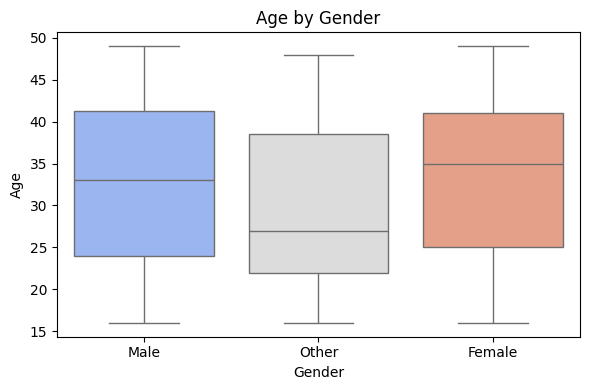

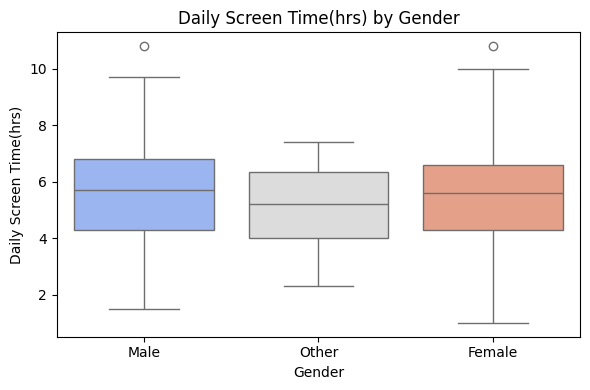

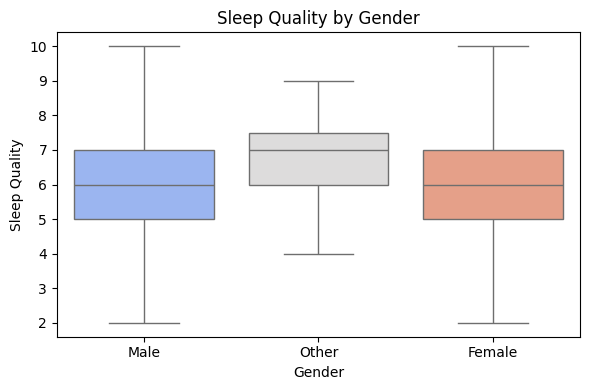

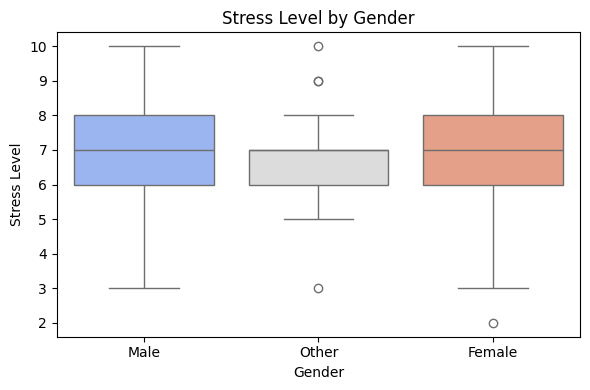

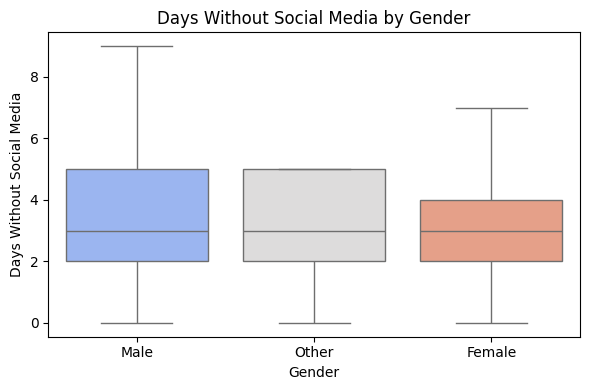

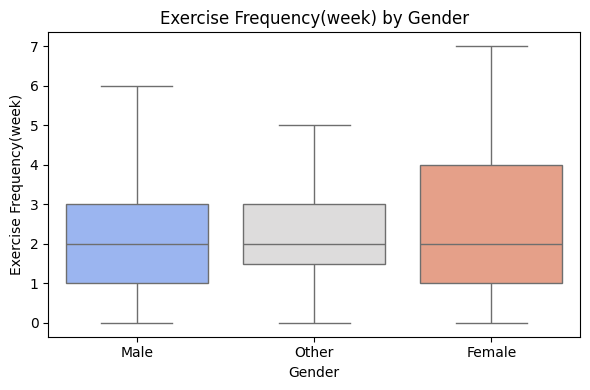

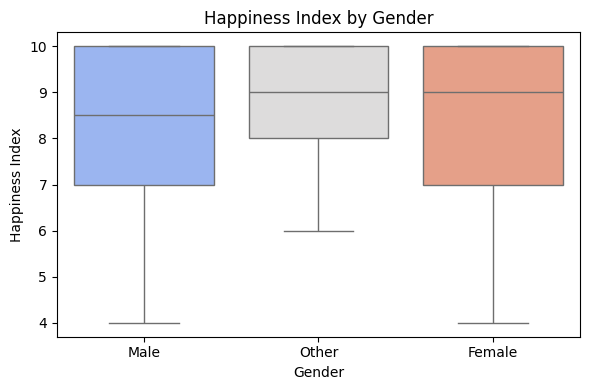

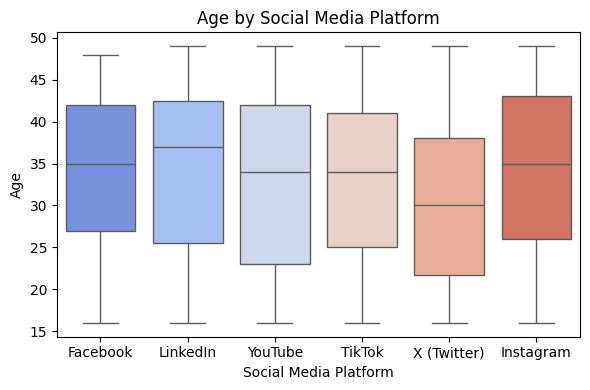

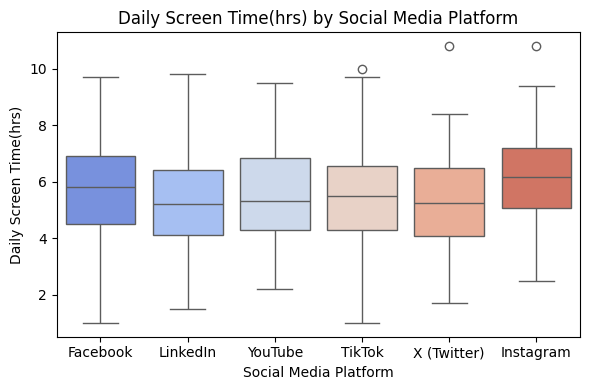

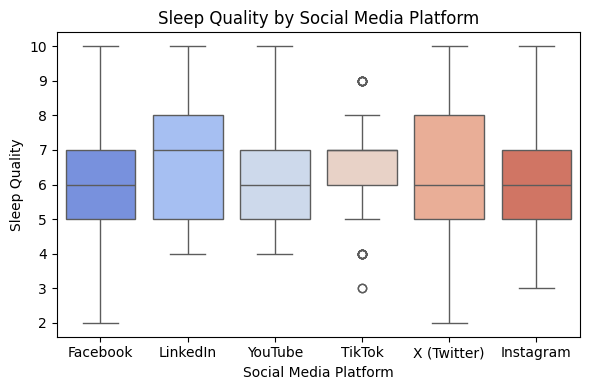

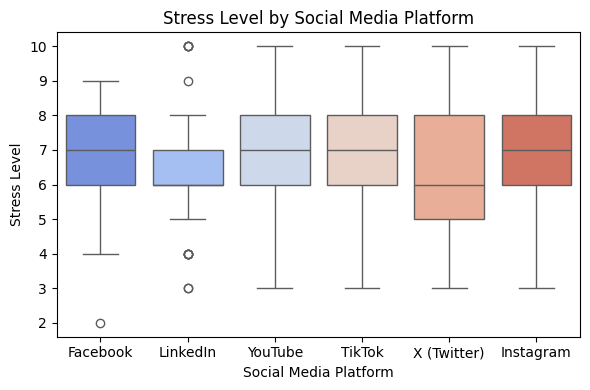

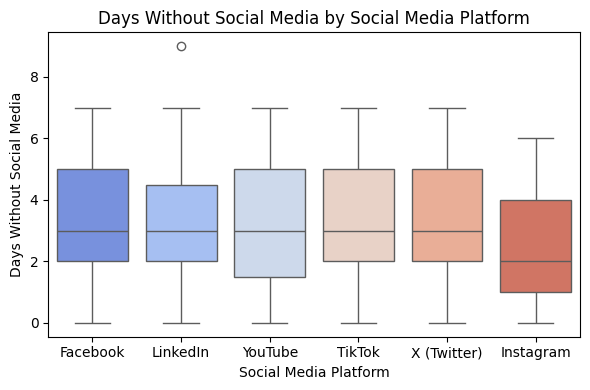

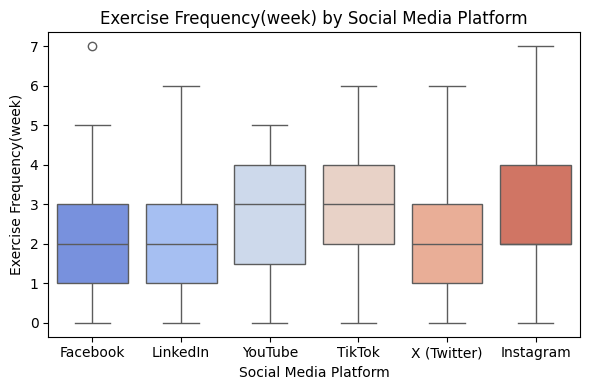

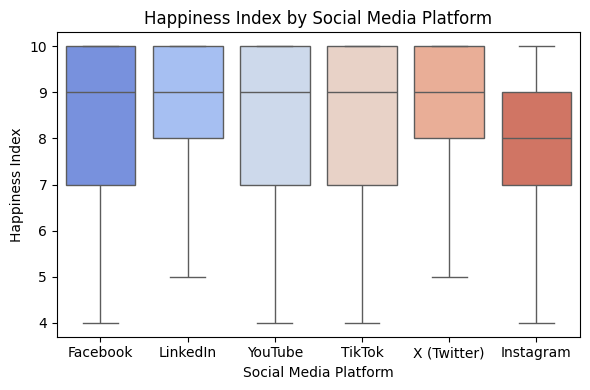

In [18]:
# Categorical vs numerical boxplots
categorical_cols = ['Gender', 'Social_Media_Platform']

for cat in categorical_cols:
    for num in numeric_cols:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=cat, y=num, data=df, palette="coolwarm")
        
        # Apply pretty labels and title
        plt.xlabel(pretty(cat))
        plt.ylabel(pretty(num))
        plt.title(f'{pretty(num)} by {pretty(cat)}')
        
        plt.tight_layout()
        plt.show()
        print("\n")

No obvious imbalance here, except minor shifts:
- there are fewer very happy people (index 10) among Instagram users than users of other platforms;
- the users of business/professionals related social media platforms (LinkedIn, Facebook, X) exercise slightly less frequently;
- the users of Instagram has slightly more days without social media platform;
- female exercise slightly more frequently than males among SMP users.

Also it gives the answers to few our questions:
- both male and female are equally exposed to stress;
- there are no significant differences in mental health metrics across age groups or gender;
- users of all platform has near to equal stress or happiness distribution levels;

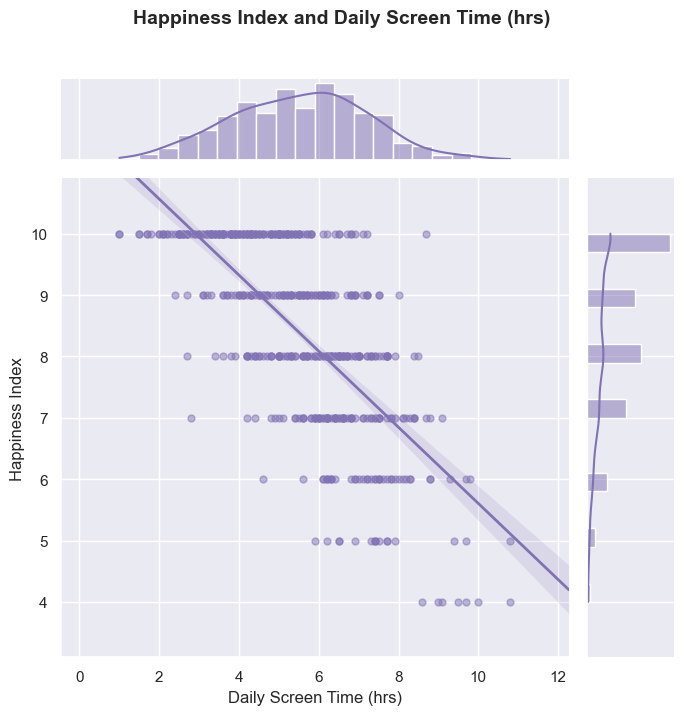

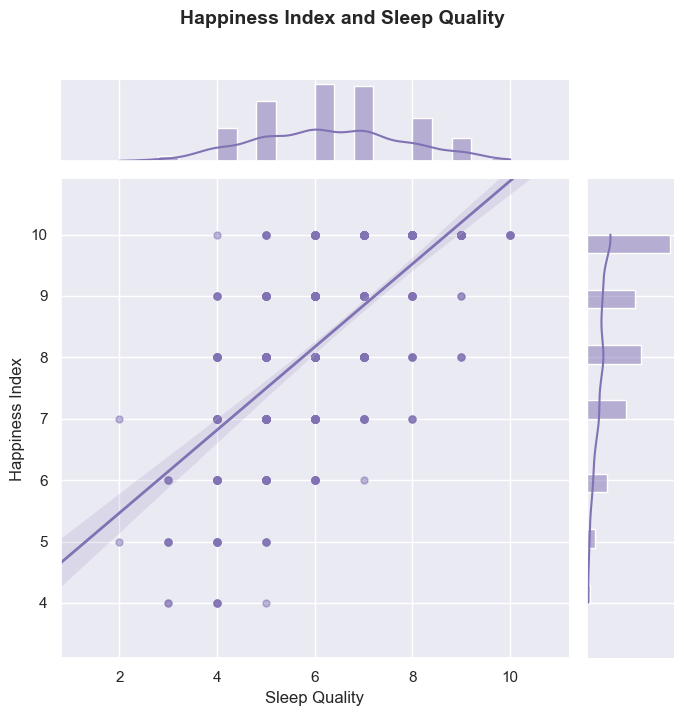

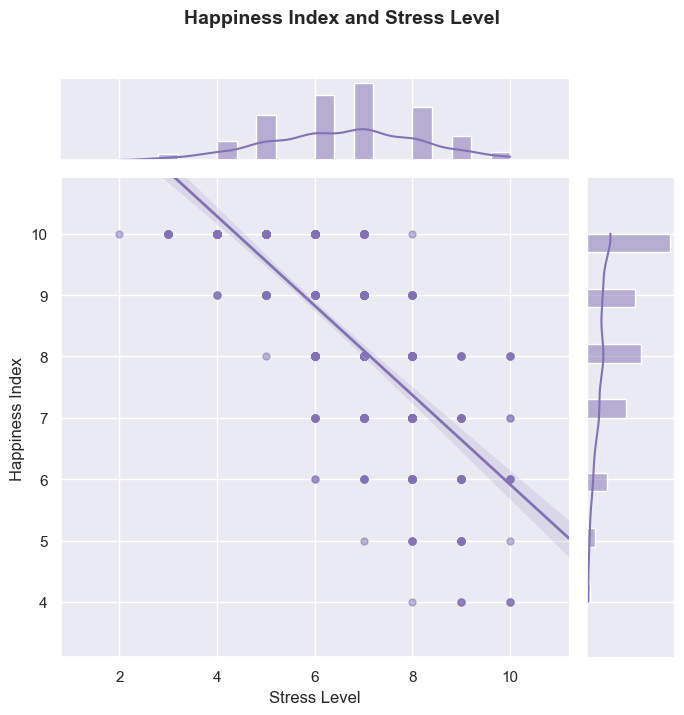

In [ ]:
sns.set_theme(style="darkgrid")

regression_pairs = [
    ("Happiness_Index(1-10)", "Daily_Screen_Time(hrs)"),
    ("Happiness_Index(1-10)", "Sleep_Quality(1-10)"),
    ("Happiness_Index(1-10)", "Stress_Level(1-10)"),
    ("Happiness_Index(1-10)", "Exercise_Frequency(week)"),
    ("Stress_Level(1-10)", "Daily_Screen_Time(hrs)"),
    ("Stress_Level(1-10)", "Sleep_Quality(1-10)"),
    ("Sleep_Quality(1-10)", "Daily_Screen_Time(hrs)")
]

# Creates a mapping for prettier titles and axis labels
pretty_labels = {
    "Happiness_Index(1-10)": "Happiness Index",
    "Stress_Level(1-10)": "Stress Level",
    "Sleep_Quality(1-10)": "Sleep Quality",
    "Daily_Screen_Time(hrs)": "Daily Screen Time (hrs)",
    "Exercise_Frequency(week)": "Exercise Frequency (week)"
}

for y_var, x_var in regression_pairs:
    # Calculate min/max and add 15% buffer on both sides
    x_min, x_max = df[x_var].min(), df[x_var].max()
    y_min, y_max = df[y_var].min(), df[y_var].max()
    
    buffer_x = (x_max - x_min) * 0.15
    buffer_y = (y_max - y_min) * 0.15
    
    xlim = (x_min - buffer_x, x_max + buffer_x)
    ylim = (y_min - buffer_y, y_max + buffer_y)

    g = sns.jointplot(
        x=x_var,
        y=y_var,
        data=df,
        kind="reg",
        truncate=False,
        height=7,
        xlim=xlim,
        ylim=ylim,
        color="m",  # magenta scatter + regression line
        marginal_kws=dict(bins=20, fill=True),
        scatter_kws=dict(alpha=0.5, s=25),
        line_kws=dict(lw=2)
    )
    
    # Custom title
    g.fig.suptitle(
        f"{pretty_labels[y_var]} and {pretty_labels[x_var]}", 
        fontsize=14, weight="bold", y=1.02
    )
    
    # Custom axis labels
    g.set_axis_labels(pretty_labels[x_var], pretty_labels[y_var], fontsize=12)
    
    # Adjust layout
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.92)
    
    plt.show()
    print('\n')
    
# Adds dependencies visualization between sleep quality and stress/happiness
# Reshape data for seaborn
df_melted = df.melt(id_vars='Sleep_Quality(1-10)',
                    value_vars=['Happiness_Index(1-10)', 'Stress_Level(1-10)'],
                    var_name='Metric',
                    value_name='Value')

# Plot double line chart
plt.figure(figsize=(10,6))
sns.lineplot(data=df_melted, x='Sleep_Quality(1-10)', y='Value', hue='Metric', marker='o')

plt.title('Happiness and Stress relations with Sleep Quality', fontsize=16)
plt.xlabel('Sleep Quality (1-10)', fontsize=12)
plt.ylabel('Index (1-10)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Paragraph Summary:
- Social media and stress: The more time users spend on social media, the more stressed they tend to be.
- Sleep and happiness: Happiness is strongly correlated with sleep quality; the more users sleep, the happier they tend to be.
- Stress, social media, and happiness: Users on social media who experience higher stress are generally less happy.
- Causality ambiguity: Higher stress levels may lead to more time spent on social media, or conversely, more social media use may increase stress levels.
- Sleep and stress: Better sleep quality helps reduce stress levels.
- Screen time and sleep: Increased daily screen time can worsen sleep quality, or alternatively, individuals with insomnia may spend more time on social media.

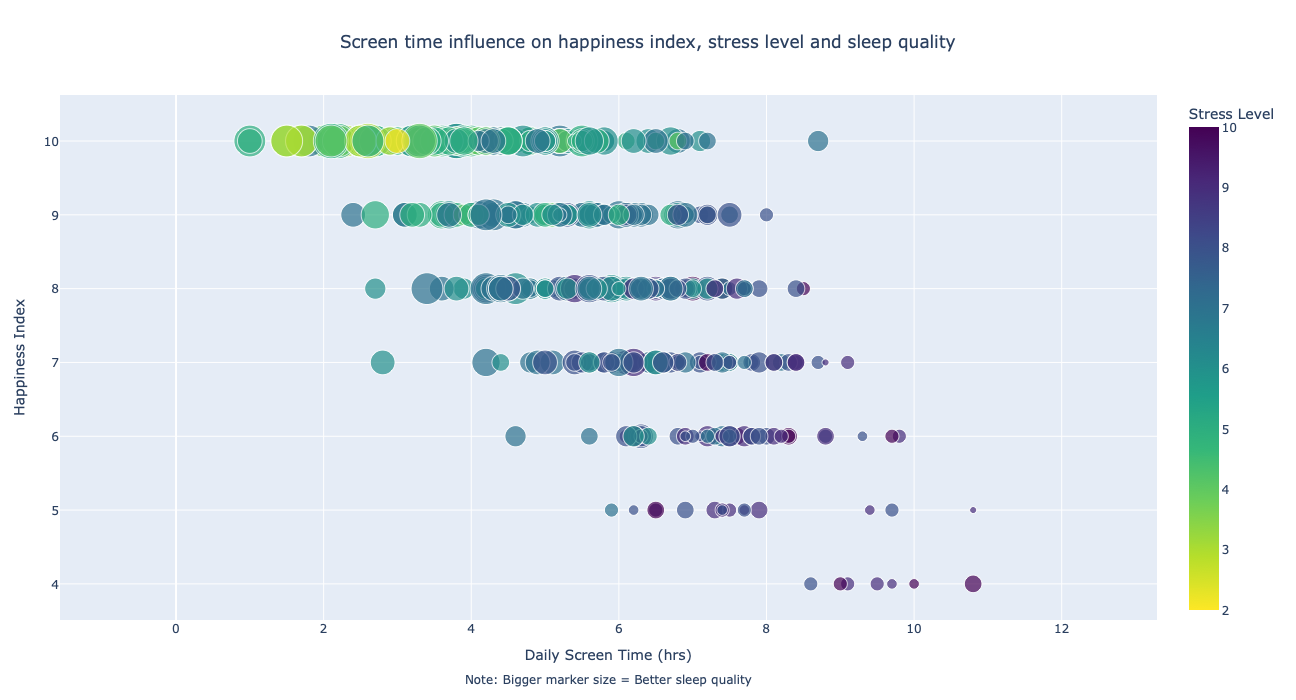

In [29]:
# Scale Sleep Quality for marker size
scaled_size = df["Sleep_Quality(1-10)"] ** 2  # adjust exponent

fig = px.scatter(
    df,
    x="Daily_Screen_Time(hrs)",
    y="Happiness_Index(1-10)",
    size=scaled_size,
    color="Stress_Level(1-10)",
    color_continuous_scale="Viridis_r",
    size_max=25,
    opacity=0.7,
    custom_data=[
        "Gender",
        "Exercise_Frequency(week)",
        "Days_Without_Social_Media",
        "Sleep_Quality(1-10)",
        "Stress_Level(1-10)"
    ]
)

# Update layout for axis titles, colorbar, annotation
fig.update_layout(
    title_text="Screen time influence on happiness index, stress level and sleep quality",
    title_x=0.5,
    width=800,
    height=700,
    autosize=False,
    margin=dict(t=95, b=80, l=60, r=50),

    # X and Y axis styling
    xaxis=dict(title="Daily Screen Time (hrs)"),
    yaxis=dict(title="Happiness Index"),
    coloraxis_colorbar=dict(title="Stress Level")
)

# Force equal aspect ratio
fig.update_yaxes(scaleanchor="x", scaleratio=1)

# Customize hover to exclude marker size
fig.update_traces(
    hovertemplate=(
        "Gender: %{customdata[0]}<br>" +
        "Exercise Frequency: %{customdata[1]}<br>" +
        "Days Without Social Media: %{customdata[2]}<br>" +
        "Daily Screen Time: %{x}<br>" +
        "Happiness Index: %{y}<br>" +
        "Sleep Quality: %{customdata[3]}<br>" +
        "Stress Level: %{customdata[4]}<extra></extra>"
    )
)

# Add annotation at the bottom
fig.add_annotation(
    xref="paper", yref="paper",
    x=0.5, y=-0.13,  # slightly below x-axis
    showarrow=False,
    text="Note: Bigger marker size = Better sleep quality",
    font=dict(size=12),
    align="center"
)

fig.show()

***Complex visualisation proves our previous observations***

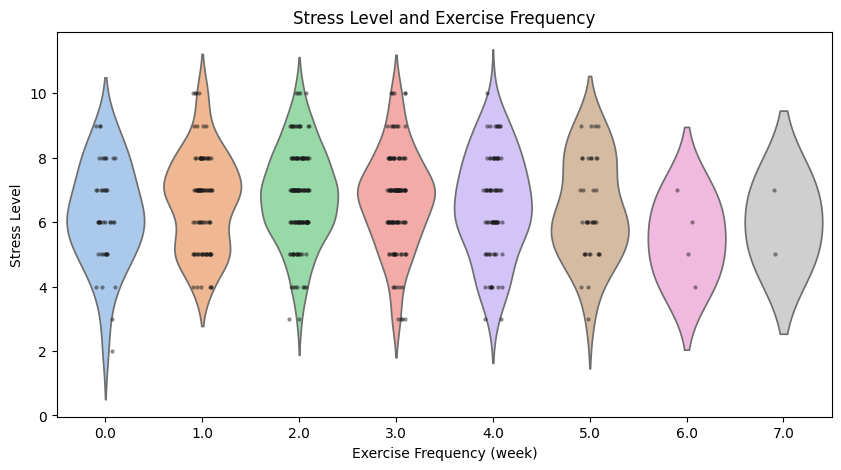

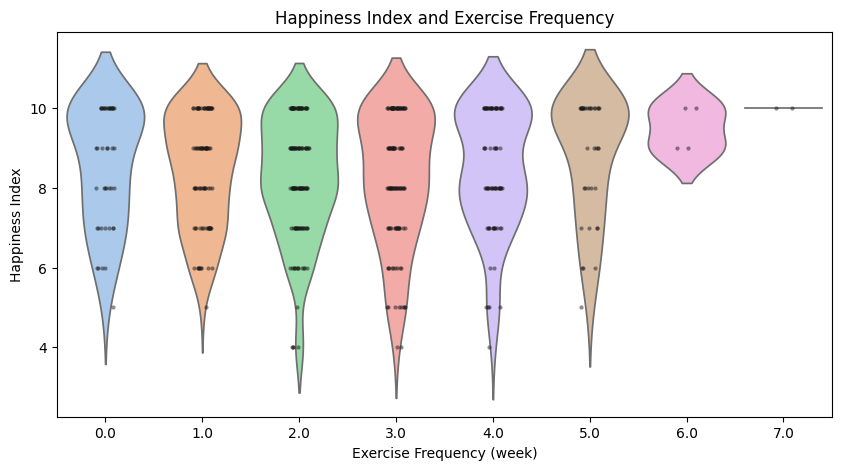

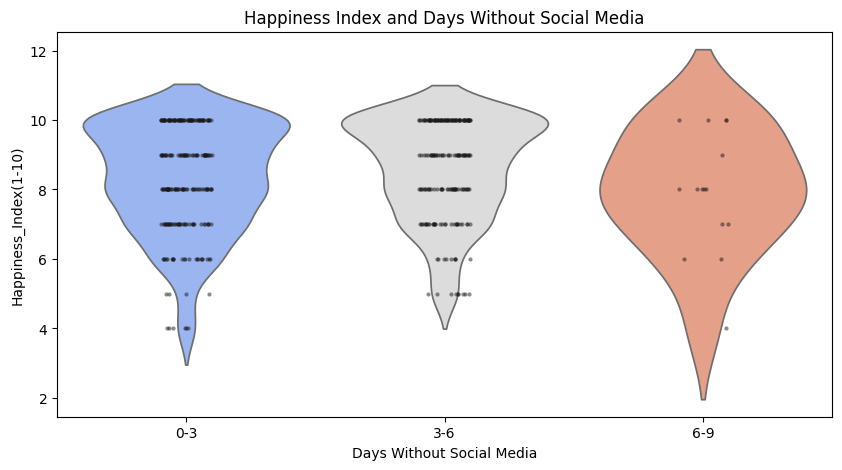

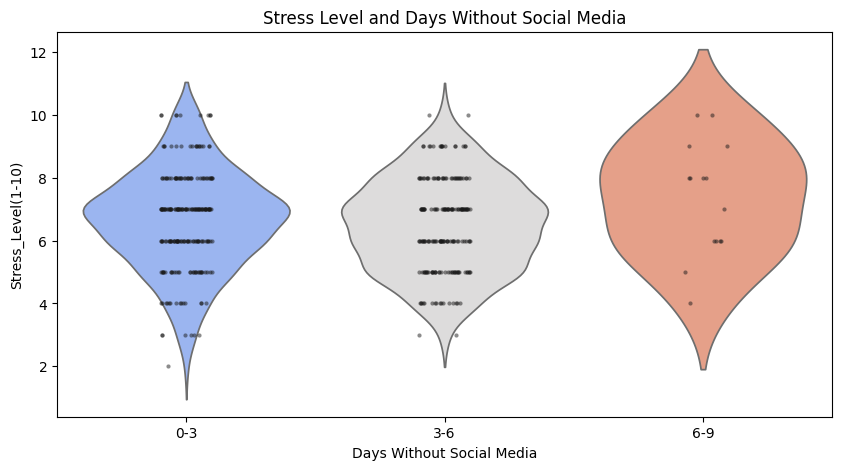

In [30]:
# Create social media break groups
break_bins = [0, 3, 6, 9]
break_labels = ['0-3', '3-6', '6-9']
df['Social_Media_Break'] = pd.cut(df['Days_Without_Social_Media'], bins=break_bins, labels=break_labels)

# ---------- 1. Exercise frequency vs mental health ----------
# Stress vs Exercise Frequency
metrics = ['Stress_Level(1-10)', 'Happiness_Index(1-10)']
for metric in metrics:
    plt.figure(figsize=(10,5))
    sns.violinplot(x='Exercise_Frequency(week)', y=metric, data=df, inner=None, palette='pastel')
    sns.stripplot(x='Exercise_Frequency(week)', y=metric, data=df, color='k', alpha=0.5, size=3, jitter=True)
    plt.title(f'{pretty(metric)} and Exercise Frequency')
    plt.xlabel('Exercise Frequency (week)')
    plt.ylabel(pretty(metric))
    plt.show()
    print("\n")

# ---------- 2. Social media break vs mental health ----------
metrics = ['Happiness_Index(1-10)', 'Stress_Level(1-10)']
for metric in metrics:
    plt.figure(figsize=(10,5))
    sns.violinplot(x='Social_Media_Break', y=metric, data=df, inner=None, palette='coolwarm')
    sns.stripplot(x='Social_Media_Break', y=metric, data=df, color='k', alpha=0.5, size=3, jitter=True)
    plt.title(f'{pretty(metric)} and Days Without Social Media')
    plt.xlabel('Days Without Social Media')
    plt.ylabel(metric)
    plt.show()
    print("\n")

df.drop(columns=['Social_Media_Break'], inplace=True)

Paragraph Summary:
- frequent exercises doesn't influence stress levels significantly by itself, but do improve overall happiness; 
- few days without Social Media by itself can't improve overall happiness or decrease stress level.

Note: later we will check mental status measures in combinations of few detox methods simultaneously.

Found 1 Balance_Score outlier(s) using IQR rule.
  Lower bound: -19.69, Upper bound: 24.71
  Outlier values:
    Balance_Score
39           48.0

Original rows: 500 → Clean rows: 499

Clean Data Summary:
       Balance_Score  Screen_per_Exercise
count        499.000              499.000
mean           3.005                2.045
std            2.814                1.419
min            0.200                0.143
25%            1.200                1.150
50%            2.258                1.625
75%            3.797                2.400
max           24.000                9.800


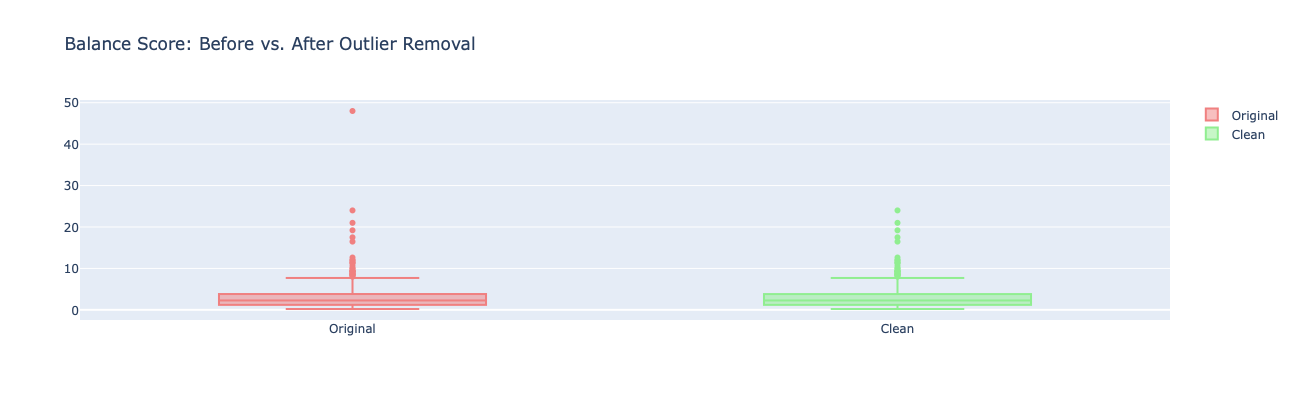

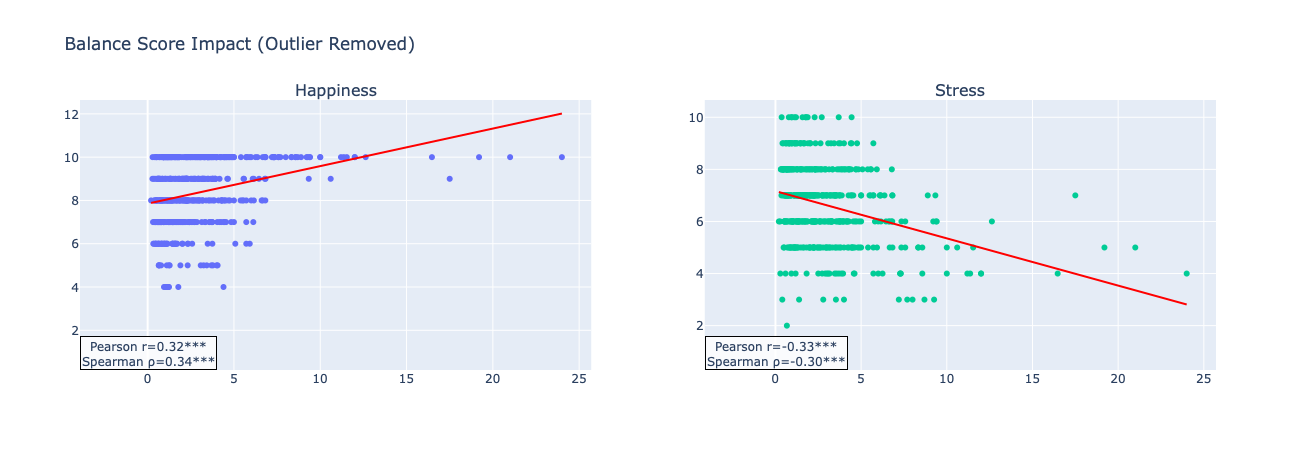

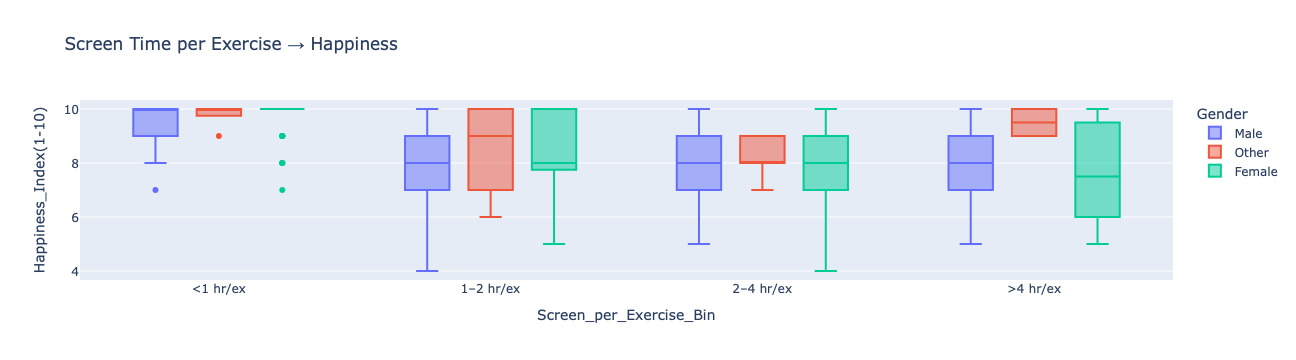

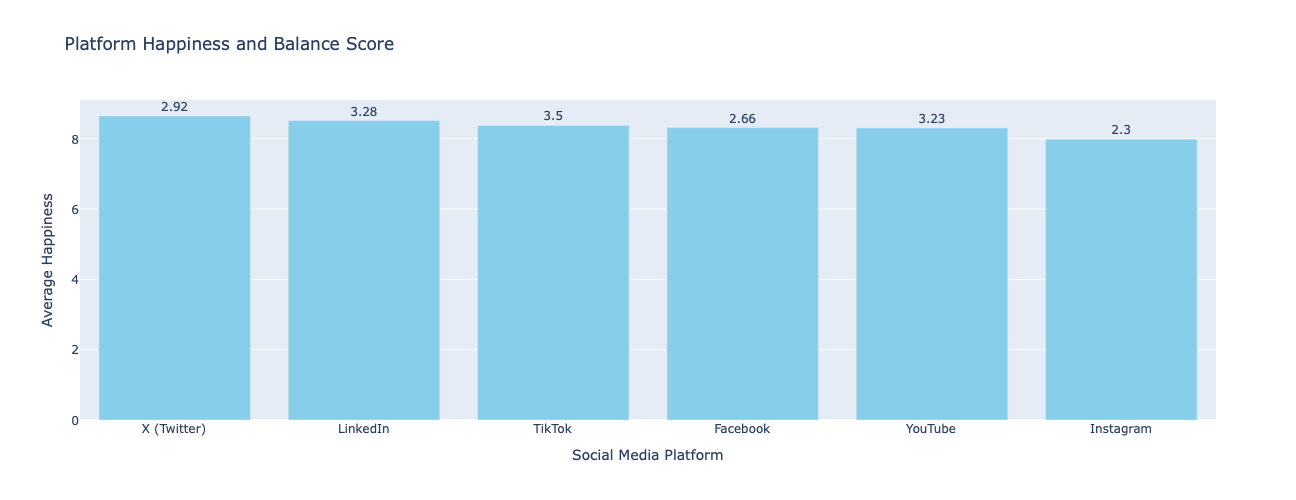

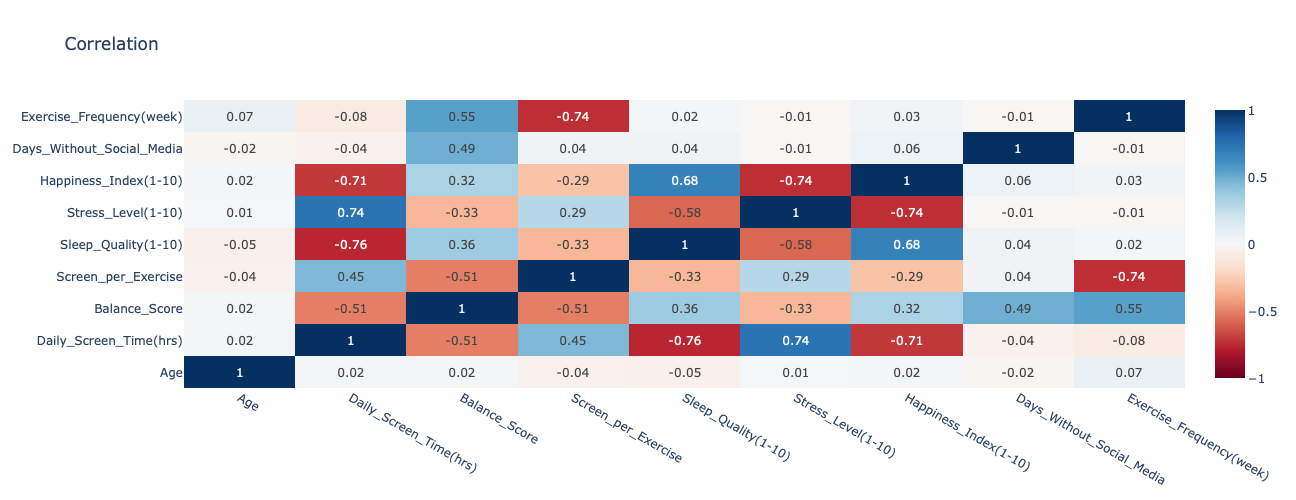

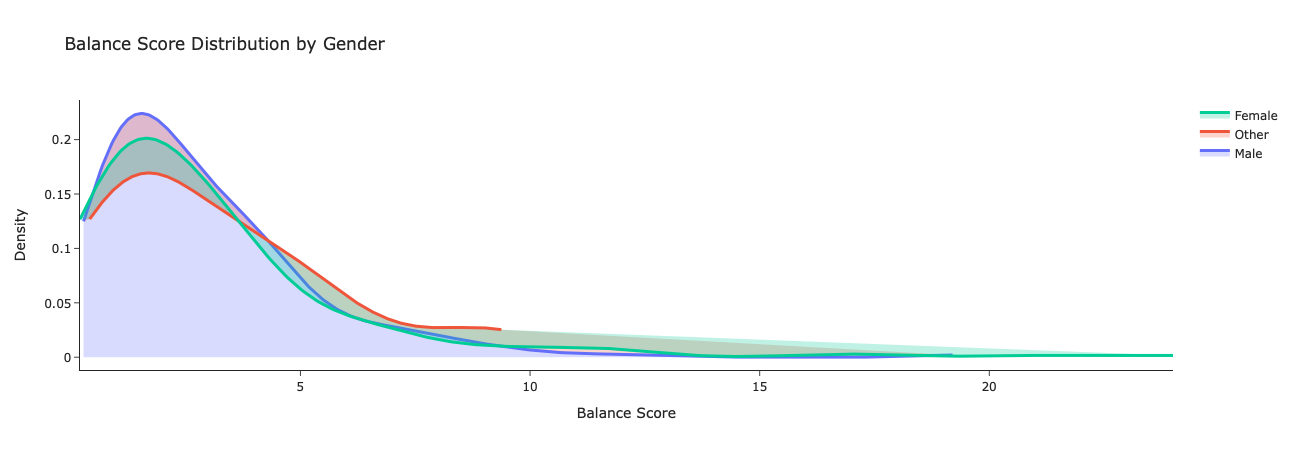

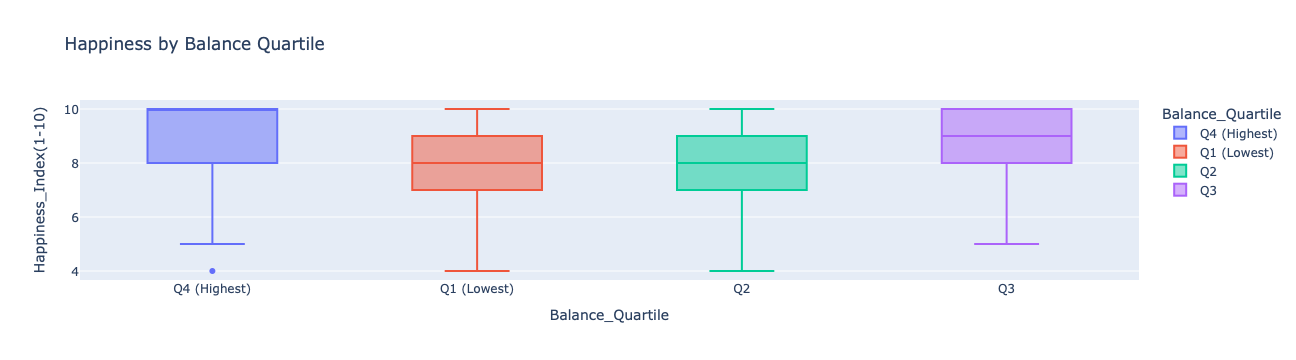

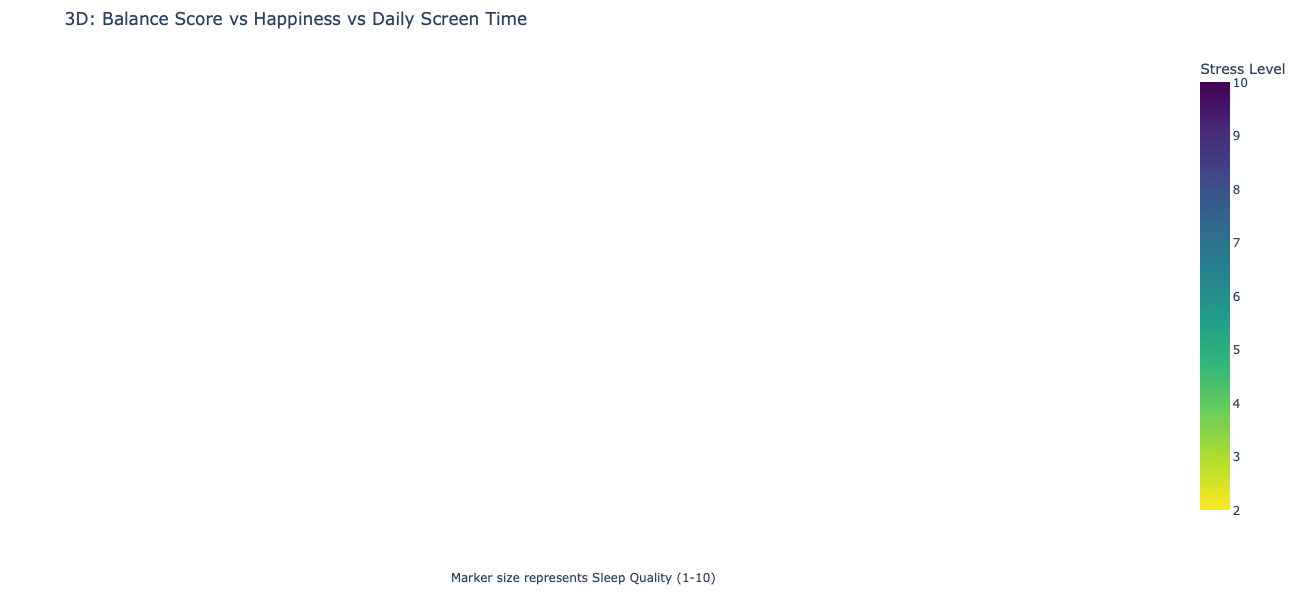

In [31]:
# Some visualizations using feature engineering columns
# Few AI used for complex visualizations and debuging

df = add_interactions(df)

# -------------------------------------------------
# 1. Detect & Drop the Balance_Score outlier
# -------------------------------------------------
# Option A – IQR method
Q1 = df['Balance_Score'].quantile(0.25)
Q3 = df['Balance_Score'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 8 * IQR # theshold 8 removes that one user that makes visuals with wrong scales, see first fig
upper = Q3 + 8 * IQR

outlier_mask = (df['Balance_Score'] < lower) | (df['Balance_Score'] > upper)
n_outliers = outlier_mask.sum()

print(f"Found {n_outliers} Balance_Score outlier(s) using IQR rule.")
print(f"  Lower bound: {lower:.2f}, Upper bound: {upper:.2f}")
if n_outliers > 0:
    print("  Outlier values:")
    print(df.loc[outlier_mask, ['Balance_Score']].round(3))

# Create clean df
df_clean = df.loc[~outlier_mask].copy()
print(f"\nOriginal rows: {len(df)} → Clean rows: {len(df_clean)}")

# Summary Stats
print("\nClean Data Summary:")
print(df_clean[['Balance_Score', 'Screen_per_Exercise']].describe().round(3))

# -------------------------------------------------
# 2. Helper – correlation annotation (adds pearson r, spearman r results in box)
# -------------------------------------------------
def add_corr(fig, x, y, row=1, col=1):
    #calculate corelations
    r_p, p_p = pearsonr(x, y)
    r_s, p_s = spearmanr(x, y)

    # stars to show strenght of corelations
    stars_p = "***" if p_p < 0.001 else "**" if p_p < 0.1 else "*" if p_p < 0.3 else ""
    stars_s = "***" if p_s < 0.001 else "**" if p_s < 0.1 else "*" if p_s < 0.3 else ""

    # anotation text
    text = f"Pearson r={r_p:.2f}{stars_p}<br>Spearman ρ={r_s:.2f}{stars_s}"

    # add text on fig bottom
    fig.add_annotation(
        text=text,
        x=0.05, y=0.95, xref=f"x{col}", yref=f"y{col}",
        showarrow=False, font_size=12,
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="black", borderwidth=1
    )

# -------------------------------------------------
# 3. Before/After Boxplot (shows impact of outlier drop) - used to adjust threshold ↑↑↑
# -------------------------------------------------
fig = go.Figure()
fig.add_trace(go.Box(y=df['Balance_Score'], name='Original', marker_color='lightcoral'))
fig.add_trace(go.Box(y=df_clean['Balance_Score'], name='Clean', marker_color='lightgreen'))
fig.update_layout(title="Balance Score: Before vs. After Outlier Removal", height=400)
fig.show()

# -------------------------------------------------
# 4. ALL 7 VISUALISATIONS – USING df_clean
# -------------------------------------------------
# 1. Balance Score vs Happiness & Stress
fig = make_subplots(rows=1, cols=2, subplot_titles=("Happiness", "Stress"))
for col, target in enumerate(['Happiness_Index(1-10)', 'Stress_Level(1-10)'], 1):
    x, y = df_clean['Balance_Score'], df_clean[target]
    fig.add_trace(go.Scatter(x=x, y=y, mode='markers',
                             name='Happy' if col==1 else 'Stress'), row=1, col=col)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    x_line = np.linspace(x.min(), x.max(), 100)
    fig.add_trace(go.Scatter(x=x_line, y=p(x_line), mode='lines',
                             line=dict(color='red'), showlegend=False), row=1, col=col)
    add_corr(fig, x, y, row=1, col=col)
fig.update_layout(title="Balance Score Impact (Outlier Removed)", height=450, showlegend=False)
fig.show()

# 2. Screen per Exercise → Happiness (binned)
bins = [0, 1, 2, 4, np.inf]
labels = ['<1 hr/ex', '1–2 hr/ex', '2–4 hr/ex', '>4 hr/ex']
df_clean['Screen_per_Exercise_Bin'] = pd.cut(df_clean['Screen_per_Exercise'], bins=bins, labels=labels)

fig = px.box(df_clean, x='Screen_per_Exercise_Bin', y='Happiness_Index(1-10)',
             color='Gender', title="Screen Time per Exercise → Happiness")
fig.show()

# 3. Platform Summary – Sorted by Happiness (Decreasing)

plat = df_clean.groupby('Social_Media_Platform').agg({
    'Balance_Score': 'mean',
    'Happiness_Index(1-10)': 'mean'
}).round(2).reset_index()

# SORT by Happiness (high → low)
plat = plat.sort_values('Happiness_Index(1-10)', ascending=False)

fig = px.bar(
    plat,
    x='Social_Media_Platform',
    y='Happiness_Index(1-10)',
    text='Balance_Score',
    title="Platform Happiness and Balance Score",
    labels={'Happiness_Index(1-10)': 'Average Happiness (1–10)'}
)

# Improve appearance
fig.update_traces(
    textposition='outside',
    marker_color='skyblue',
    textfont_size=12
)
fig.update_layout(
    xaxis_title="Social Media Platform",
    yaxis_title="Average Happiness",
    height=500,
    showlegend=False
)

fig.show()

# 4. Correlation Heatmap
corr_cols = ['Age', 'Daily_Screen_Time(hrs)', 'Balance_Score', 'Screen_per_Exercise',
             'Sleep_Quality(1-10)', 'Stress_Level(1-10)', 'Happiness_Index(1-10)', 'Days_Without_Social_Media', 
             'Exercise_Frequency(week)']
corr = df_clean[corr_cols].corr().round(2)
fig = go.Figure(data=go.Heatmap(z=corr.values, x=corr.columns, y=corr.columns,
                                colorscale='RdBu', zmid=0, text=corr.values, texttemplate="%{text}"))
fig.update_layout(title="Correlation", height=500)
fig.show()

# 5. Balance Score Distribution by Gender

# Helper to convert hex to rgba for transparency
def hex_to_rgba(hex_color, alpha=0.25):
    hex_color = hex_color.lstrip('#')
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return f'rgba({r},{g},{b},{alpha})'

fig = go.Figure()

# Dynamic colors for genders
unique_genders = df_clean['Gender'].unique()
color_palette = px.colors.qualitative.Plotly
gender_colors = {g: color_palette[i % len(color_palette)] for i, g in enumerate(unique_genders)}

for gender in unique_genders:
    data = df_clean.loc[df_clean['Gender'] == gender, 'Balance_Score']
    if len(data) < 2:
        continue
    
    # KDE
    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 500)
    y_vals = kde(x_vals)
    
    # Smooth filled curve
    fig.add_trace(go.Scatter(
        x=x_vals,
        y=y_vals,
        mode='lines',
        name=gender,
        line=dict(color=gender_colors[gender], width=3),
        fill='tonexty',
        fillcolor=hex_to_rgba(gender_colors[gender], alpha=0.25)
    ))

fig.update_layout(
    title="Balance Score Distribution by Gender",
    xaxis_title="Balance Score",
    yaxis_title="Density",
    template='simple_white',
    height=450
)

fig.show()

# 6. Happiness by Balance Quartile
df_clean['Balance_Quartile'] = pd.qcut(df_clean['Balance_Score'], 4,
                                      labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'])
fig = px.box(df_clean, x='Balance_Quartile', y='Happiness_Index(1-10)',
             color='Balance_Quartile', title="Happiness by Balance Quartile")
fig.show()

## 7. 3D Scatter

# Marker sizes (Sleep Quality)
sizes = df_clean['Sleep_Quality(1-10)']

# Compute sizeref for small markers
max_desired_marker_size = 20  # max diameter in pixels
sizeref = 2.0 * max_desired_marker_size / (sizes.max() ** 2)

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=df_clean['Balance_Score'],
    y=df_clean['Happiness_Index(1-10)'],
    z=df_clean['Daily_Screen_Time(hrs)'],
    mode='markers',
    marker=dict(
        size=sizes,
        sizemode='diameter',
        sizeref=sizeref,
        color=df_clean['Stress_Level(1-10)'],
        colorscale='Viridis_r',  # reversed color gradient
        colorbar=dict(title='Stress Level'),  # full size
        opacity=0.8
    ),
    text=df_clean['Social_Media_Platform'],
    hovertemplate=
        "Balance Score: %{x:.2f}<br>" +
        "Happiness: %{y}<br>" +
        "Daily Screen Time: %{z:.2f} hrs<br>" +
        "Sleep Quality: %{marker.size:.1f}<br>" +
        "Stress: %{marker.color}<br>" +
        "Platform: %{text}"
))

# Add annotation at bottom for marker size meaning
fig.add_annotation(
    text="Marker size represents Sleep Quality (1-10)",
    xref="paper", yref="paper",
    x=0.5, y=-0.1,
    showarrow=False,
    font=dict(size=12),
    xanchor='center', yanchor='top'
)

# Layout
fig.update_layout(
    title="3D: Balance Score vs Happiness vs Daily Screen Time",
    height=600,
    margin=dict(l=0, r=0, b=80, t=50),  # space for bottom annotation
    paper_bgcolor='white',
    plot_bgcolor='white',
    scene=dict(
        xaxis=dict(title='Balance Score', backgroundcolor='white', gridcolor='lightgray', showbackground=True),
        yaxis=dict(title='Happiness Index (1-10)', backgroundcolor='white', gridcolor='lightgray', showbackground=True),
        zaxis=dict(title='Daily Screen Time (hrs)', backgroundcolor='white', gridcolor='lightgray', showbackground=True),
        aspectmode='cube'
    )
)

fig.show()

Paragraph summary:
- A simultanious combination of regular exercise and designated days without social media can increase happiness and reduce stress.
- To minimize the impact of social media on mental health, daily screen time should be limited to under one hour, and exercise should be performed every day;
- Instagram users are the most unhappy among other SMP users and also have the worst balance score;
- Both genders have the same balance score spread (screen time | days without SMP | frequent exercises)

---
## 5. Machine Learning 
---

Goal is to create a model to predict Level of Happiness and Stress Level by parameters: "Age", "Daily_Screen_Time(hrs)","Exercise_Frequency(week)", "Days_Without_Social_Media", "Sleep_Quality(1-10)".

In [ ]:
# Checks what to Keep vs Drop
# Drop target + ID column
df_clean = df.drop(columns=["User_ID", "Happiness_Index(1-10)", "Stress_Level(1-10)"], errors="ignore")

# One-hot encode categorical features automatically
X = pd.get_dummies(df_clean)

# Target
y = df["Happiness_Index(1-10)"]

# Train model
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns)

# Sort smallest → largest
importances = importances.sort_values()

print(importances)

***Decided to drop Gender parameter as it have extremely small importance, meaning it add noise but not predictive value***

In [32]:
# MODEL of ML; used Optuna to pick up the best parameters for precisiness of RandomForestRegressor algorithm

# ------------------------------
# 1. Load dataset
# ------------------------------

# feature design columns are already in df

X = df[[
    "Age",
    "Daily_Screen_Time(hrs)",
    "Social_Media_Platform",
    "Exercise_Frequency(week)",
    "Days_Without_Social_Media",
    "Sleep_Quality(1-10)",
    "Balance_Score",
    "Screen_per_Exercise"
]]

y = df[["Happiness_Index(1-10)", "Stress_Level(1-10)"]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==========================================================
# 2. Preprocessing
# ==========================================================
cat_features = ["Social_Media_Platform"]

num_features = [
    "Age",
    "Daily_Screen_Time(hrs)",
    "Exercise_Frequency(week)",
    "Days_Without_Social_Media",
    "Sleep_Quality(1-10)",
    "Balance_Score",
    "Screen_per_Exercise"
]

# Winsorizer for engineered interactions
winsorizer = Winsorizer(
    capping_method="iqr",
    tail="both",
    fold=1.5,
    variables=["Balance_Score", "Screen_per_Exercise"]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("num", "passthrough", num_features)
    ]
)

# ==========================================================
# 3. Optuna Objective
# ==========================================================
def objective(trial):

    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)

    model = MultiOutputRegressor(
        TransformedTargetRegressor(
            regressor=RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            ),
            transformer=MinMaxScaler(feature_range=(0, 10))
        )
    )

    pipeline = Pipeline([
        ("winsor", winsorizer),
        ("preprocess", preprocessor),
        ("model", model)
    ])

    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

# ==========================================================
# 4. Run Optuna
# ==========================================================
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)
print("Best params:", study.best_params)

# ==========================================================
# 5. Train Final Model
# ==========================================================
best_params = study.best_params

final_model = MultiOutputRegressor(
    TransformedTargetRegressor(
        regressor=RandomForestRegressor(
            **best_params,
            random_state=42
        ),
        transformer=MinMaxScaler(feature_range=(0, 10))
    )
)

final_pipeline = Pipeline([
    ("winsor", winsorizer),
    ("preprocess", preprocessor),
    ("model", final_model)
])

final_pipeline.fit(X_train, y_train)

# ==========================================================
# 6. Predict New User
# ==========================================================
new_user = pd.DataFrame([{
    "Age": 27,
    "Daily_Screen_Time(hrs)": 3.2,
    "Social_Media_Platform": "Instagram",
    "Exercise_Frequency(week)": 4,
    "Days_Without_Social_Media": 1,
    "Sleep_Quality(1-10)": 6,
}])

# Must manually add engineered features for new samples
new_user["Balance_Score"] = (new_user["Exercise_Frequency(week)"]+1) * (new_user["Days_Without_Social_Media"]+1) / new_user["Daily_Screen_Time(hrs)"]
new_user["Screen_per_Exercise"] = new_user["Daily_Screen_Time(hrs)"] / (new_user["Exercise_Frequency(week)"] + 1)

prediction = final_pipeline.predict(new_user)
happiness, stress = prediction[0]

print("Predicted Happiness:", round(happiness, 2))
print("Predicted Stress:", round(stress, 2))

# ==========================================================
# 7. Save Model
# ==========================================================
with open("optimized_happiness_stress_model.pkl", "wb") as f:
    pickle.dump(final_pipeline, f)

Best params: {'n_estimators': 226, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 2}
Predicted Happiness: 9.29
Predicted Stress: 5.23


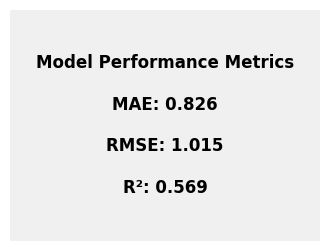

In [33]:
# Model Preciseness Metrics

# Predictions on test set
y_pred = final_pipeline.predict(X_test)

# 1. MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)

# 2. RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# 3. R² (Coefficient of Determination)
r2 = r2_score(y_test, y_pred)

from matplotlib.patches import FancyBboxPatch

# Create figure and axes
fig, ax = plt.subplots(figsize=(4, 3))
ax.axis('off')  # Hide axes

# Draw card background
card = FancyBboxPatch(
    (0, 0), 1, 1, boxstyle="round,pad=0.05", linewidth=2, edgecolor='black', facecolor='#f0f0f0'
)
ax.add_patch(card)

# Add text
text = f"Model Performance Metrics\n\nMAE: {mae:.3f}\n\nRMSE: {rmse:.3f}\n\nR²: {r2:.3f}"
ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=12, weight='bold', family='sans-serif')

plt.show()

***Those metrics are actually quite solid for a psychological / behavioral regression model — especially considering:
2 targets (multi-output),
very noisy human self-reported variables,
non-linear interaction effects,
small dataset***

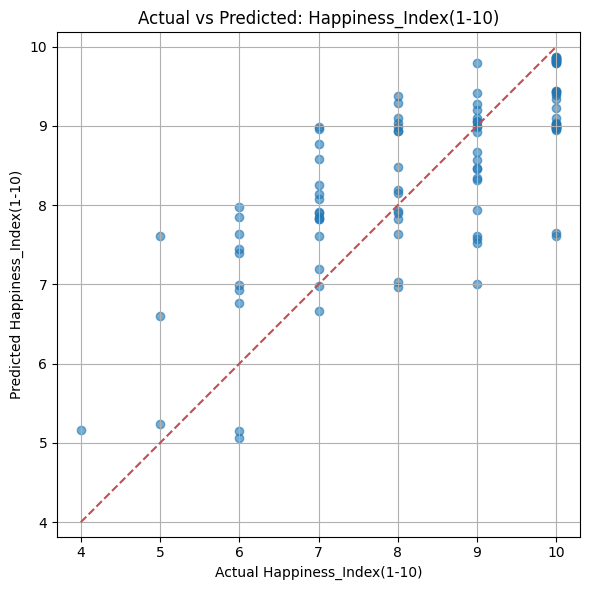

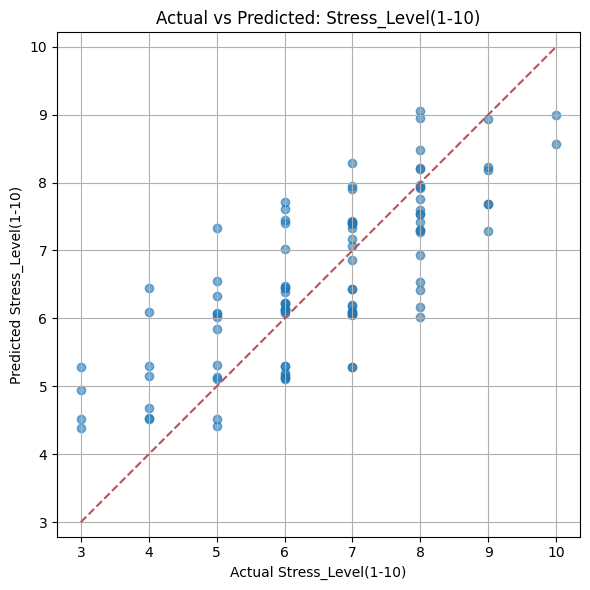

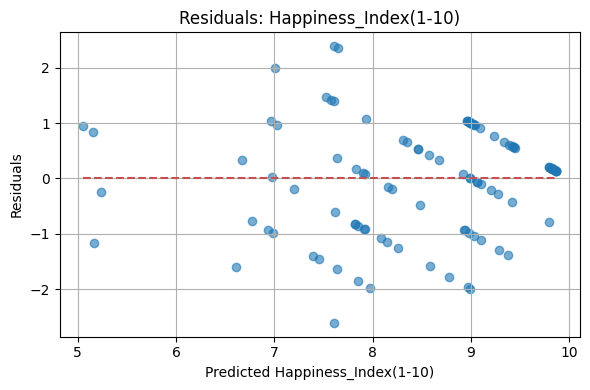

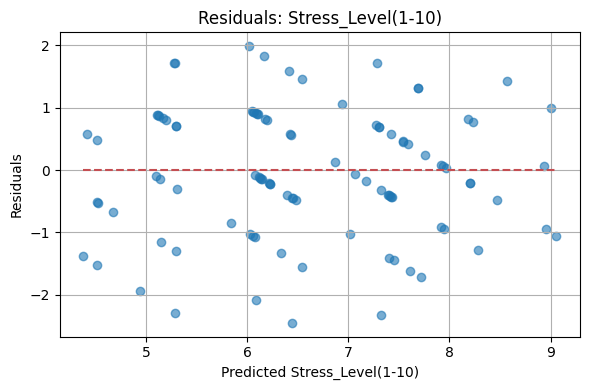

In [34]:
# Visualization of mistakes frames

# Ensure default Matplotlib style
plt.style.use('default')  # reset to normal
plt.rcParams['font.family'] = 'sans-serif'  # default clean font

# Predict on the test set
y_pred = final_pipeline.predict(X_test)

# Convert to DataFrame for easier handling
y_test_df = y_test.reset_index(drop=True)
y_pred_df = pd.DataFrame(y_pred, columns=y_test.columns)

# 1 Scatter plots: Actual vs Predicted
for col in y_test.columns:
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_df[col], y_pred_df[col], alpha=0.6)
    plt.plot([y_test_df[col].min(), y_test_df[col].max()],
             [y_test_df[col].min(), y_test_df[col].max()], 'r--')  # perfect line
    plt.xlabel(f"Actual {col}")
    plt.ylabel(f"Predicted {col}")
    plt.title(f"Actual vs Predicted: {col}")
    plt.grid(True)
    plt.axis('equal')   # keeps line at 45°
    plt.tight_layout()
    plt.show()

# 2 Residual plots
residuals = y_test_df - y_pred_df
for col in y_test.columns:
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred_df[col], residuals[col], alpha=0.6)
    plt.hlines(y=0, xmin=y_pred_df[col].min(), xmax=y_pred_df[col].max(),
               colors='r', linestyles='--')
    plt.xlabel(f"Predicted {col}")
    plt.ylabel("Residuals")
    plt.title(f"Residuals: {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

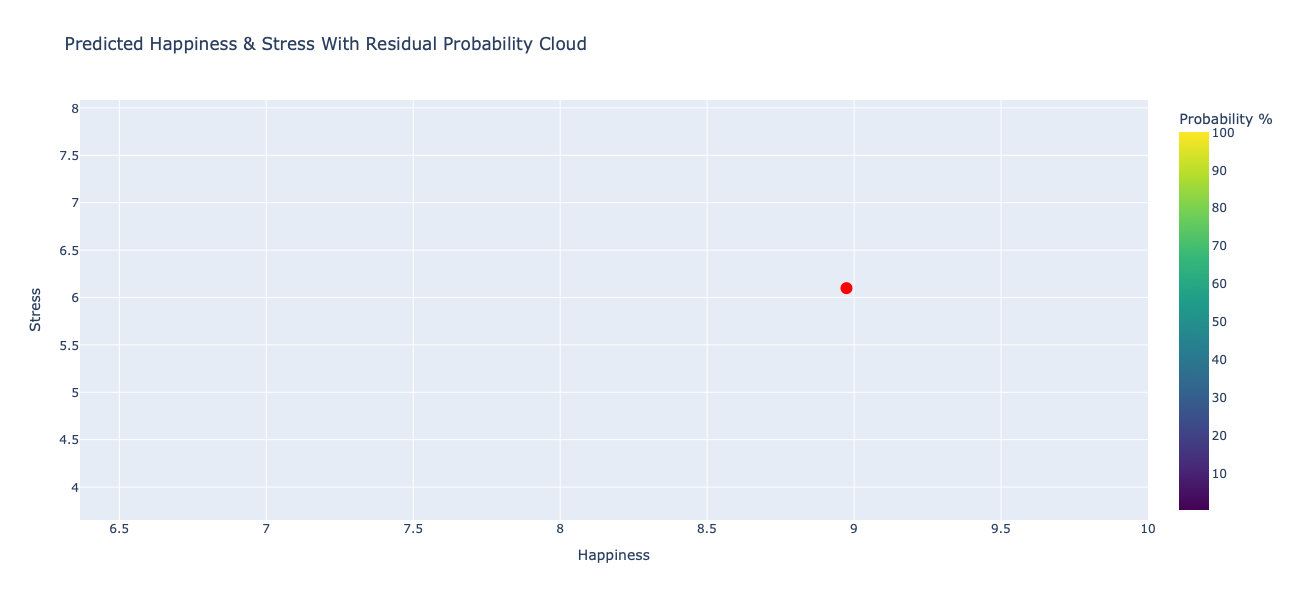

In [35]:
# Visualization of prediction with brobability cloud
# AI used for visualisation enchancment

# --------------------------------------------
# 1. Prepare new_user (must add engineered features!)
# --------------------------------------------
new_user = pd.DataFrame([{
    "Age": 27,
    "Daily_Screen_Time(hrs)": 4.2,
    "Social_Media_Platform": "Instagram",
    "Exercise_Frequency(week)": 4,
    "Days_Without_Social_Media": 1,
    "Sleep_Quality(1-10)": 6
}])

# Add engineered features (since pipeline no longer does it)
new_user["Balance_Score"] = (
    (new_user["Exercise_Frequency(week)"] + 1) *
    (new_user["Days_Without_Social_Media"] + 1) /
    new_user["Daily_Screen_Time(hrs)"]
)

new_user["Screen_per_Exercise"] = (
    new_user["Daily_Screen_Time(hrs)"] /
    (new_user["Exercise_Frequency(week)"] + 1)
)

# Predict
prediction = final_pipeline.predict(new_user)
happiness_pred = prediction[0][0]
stress_pred = prediction[0][1]


# --------------------------------------------
# 2. Compute residuals on test set
# --------------------------------------------
# The test set X_test also have engineered features
X_test_fe = X_test.copy()

X_test_fe["Balance_Score"] = (
    (X_test_fe["Exercise_Frequency(week)"] + 1) *
    (X_test_fe["Days_Without_Social_Media"] + 1) /
    X_test_fe["Daily_Screen_Time(hrs)"]
)

X_test_fe["Screen_per_Exercise"] = (
    X_test_fe["Daily_Screen_Time(hrs)"] /
    (X_test_fe["Exercise_Frequency(week)"] + 1)
)

# Prediction on enhanced test set
y_test_pred = final_pipeline.predict(X_test_fe)

y_test_df = y_test.reset_index(drop=True)
y_test_pred_df = pd.DataFrame(y_test_pred, columns=y_test.columns)

residuals = y_test_df - y_test_pred_df

happiness_min = max(happiness_pred + residuals["Happiness_Index(1-10)"].min(), 0)
happiness_max = min(happiness_pred + residuals["Happiness_Index(1-10)"].max(), 10)
stress_min = max(stress_pred + residuals["Stress_Level(1-10)"].min(), 0)
stress_max = min(stress_pred + residuals["Stress_Level(1-10)"].max(), 10)


# --------------------------------------------
# 3. Create probability cloud grid
# --------------------------------------------
grid_size = 200
happiness_grid = np.linspace(happiness_min, happiness_max, grid_size)
stress_grid = np.linspace(stress_min, stress_max, grid_size)
H, S = np.meshgrid(happiness_grid, stress_grid)

happiness_std = residuals["Happiness_Index(1-10)"].std()
stress_std = residuals["Stress_Level(1-10)"].std()

Z = np.exp(
    -(((H - happiness_pred)**2)/(2 * happiness_std**2) +
      ((S - stress_pred)**2)/(2 * stress_std**2))
)

Z_percent = (Z / Z.max()) * 100


# --------------------------------------------
# 4. Plot heatmap with Plotly
# --------------------------------------------
fig = go.Figure()

fig.add_trace(go.Heatmap(
    z=Z_percent,
    x=happiness_grid,
    y=stress_grid,
    colorscale='Viridis',
    colorbar=dict(title='Probability %'),
    zsmooth='best'
))

fig.add_trace(go.Scatter(
    x=[happiness_pred],
    y=[stress_pred],
    mode='markers',
    marker=dict(color='red', size=12),
    name='Predicted Value'
))

fig.update_layout(
    title='Predicted Happiness & Stress With Residual Probability Cloud',
    xaxis_title='Happiness',
    yaxis_title='Stress',
    xaxis=dict(range=[happiness_min, happiness_max]),
    yaxis=dict(range=[stress_min, stress_max]),
    width=600,
    height=600
)

fig.show()

In [36]:
# Gradio Interface build for user inputs and prediction visualisation
# Assisted AI built

# Load trained model
with open("optimized_happiness_stress_model.pkl", "rb") as f:
    model = pickle.load(f)

def predict_and_plot(age, screen_time, platform, exercise, days_off, sleep_quality):
    # --- Feature Engineering ---
    df = pd.DataFrame([{
        "Age": age,
        "Daily_Screen_Time(hrs)": screen_time,
        "Social_Media_Platform": platform,
        "Exercise_Frequency(week)": exercise,
        "Days_Without_Social_Media": days_off,
        "Sleep_Quality(1-10)": sleep_quality
    }])
    
    # Prevent division by zero
    safe_screen_time = screen_time if screen_time > 0 else 0.1
    
    df["Balance_Score"] = ((exercise + 1) * (days_off + 1)) / safe_screen_time
    df["Screen_per_Exercise"] = safe_screen_time / (exercise + 1)

    # --- Prediction ---
    pred = model.predict(df)[0]
    happiness_pred, stress_pred = pred

    # --- Probability Cloud ---
    grid_size = 200
    h_min, h_max = max(happiness_pred - 2, 0), min(happiness_pred + 2, 10)
    s_min, s_max = max(stress_pred - 2, 0), min(stress_pred + 2, 10)
    H, S = np.meshgrid(np.linspace(h_min, h_max, grid_size), np.linspace(s_min, s_max, grid_size))
    Z = np.exp(-(((H - happiness_pred)**2)/1.5 + ((S - stress_pred)**2)/1.5))
    Z_percent = (Z / Z.max()) * 100

    # Create Plotly figure
    fig = go.Figure()
    fig.add_trace(go.Heatmap(
        z=Z_percent,
        x=np.linspace(h_min, h_max, grid_size),
        y=np.linspace(s_min, s_max, grid_size),
        colorscale="Viridis",
        colorbar=dict(title="Probability %")
    ))
    fig.add_trace(go.Scatter(
        x=[happiness_pred],
        y=[stress_pred],
        mode="markers+text",
        text=["You"],
        textposition="top center",
        marker=dict(color="red", size=12),
    ))
    fig.update_layout(
        title="Predicted Happiness vs Stress Probability Cloud",
        xaxis_title="Happiness (1–10)",
        yaxis_title="Stress (1–10)",
        height=600,
        width=600
    )

    return round(happiness_pred, 2), round(stress_pred, 2), fig


# --- Build Interactive UI ---
with gr.Blocks() as demo:
    gr.Markdown("# 😊 Happiness & Stress Predictor")
    gr.Markdown("Adjust your daily habits and lifestyle below:")

    # First row: Age & Screen Time
    with gr.Row():
        age = gr.Slider(16, 100, value=27, step=1, label="Age")
        screen_time = gr.Slider(0, 24, value=3.2, step=0.1, label="Daily Screen Time (hrs)")

    # Second row: Platform & Exercise
    with gr.Row():
        platform = gr.Radio(["Instagram", "Facebook", "TikTok", "Twitter", "LinkedIn"], label="Social Media Platform")
        exercise = gr.Slider(0, 7, value=4, step=1, label="Exercise Frequency (per week)")

    # Third row: Days Off & Sleep Quality
    with gr.Row():
        days_off = gr.Slider(0, 28, value=1, step=1, label="Days Without Social Media")
        sleep_quality = gr.Slider(1, 10, value=6, step=1, label="Sleep Quality (1–10)")

    # Outputs
    btn = gr.Button("Predict Happiness & Stress")
    happiness = gr.Number(label="Predicted Happiness (1–10)")
    stress = gr.Number(label="Predicted Stress (1–10)")
    plot = gr.Plot(label="Visualization")  # height controlled inside Plotly figure

    # Link button to prediction function
    btn.click(
        fn=predict_and_plot,
        inputs=[age, screen_time, platform, exercise, days_off, sleep_quality],
        outputs=[happiness, stress, plot]
    )

# Launch full browser interface for full height (no scrollbars)
demo.launch(inline=False)

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


## Grand Summary:

### Data Insights

- The dataset is well-balanced across **gender** and **social media platform usage**, ensuring fair representation for analysis.  
- Overall, **stress exposure and happiness distribution are similar across genders, age groups, and platforms**, indicating broad patterns in mental health metrics.  

#### Lifestyle and Screen Time
- **Daily screen time** should ideally be **under one hour**, and **exercise should be performed regularly** for optimal mental health.  
- While frequent exercise or short periods without social media alone offer limited benefits, **combining regular exercise with designated social media-free days can significantly increase happiness and reduce stress**.  
- **Females** generally exercise slightly more frequently.  

#### Social Media Platforms
- **Instagram users** have the lowest happiness levels and worst balance scores among social media platform users.  
- Users of professional platforms (LinkedIn, Facebook, X) exercise slightly less frequently.  

#### Mental Health Correlations
- **Social media usage and stress**: Higher usage tends to correlate with higher stress levels.  
- **Stress and happiness**: Users with higher stress are generally less happy.  
- **Sleep and happiness**: Better sleep quality strongly correlates with higher happiness.  
- **Sleep and stress**: Better sleep reduces stress.  
- **Screen time and sleep**: High daily screen time may worsen sleep quality, or poor sleepers may spend more time on social media.  
- **Causality ambiguity**: Stress and social media use are closely linked, though the direction of causality is unclear—higher stress may lead to more social media use, or increased social media use may elevate stress.
